# ECGR 5105 Final Project: FAA Flight Delay Dataset
**Owen Bailey-Waltz (801488178)**

[Link to dataset on Kaggle](https://www.kaggle.com/datasets/hrishitpatil/flight-data-2024)

In [1]:
# import required packages, load data
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from sklearn import datasets, metrics
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, SVR
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from google.colab import drive
from IPython.display import display

In [2]:
# check for CUDA
device = (torch.device('cuda') if torch.cuda.is_available()
          else torch.device('cpu'))
print(f'Now training on device {device}')

Now training on device cuda


In [3]:
# linear gradient descent with loss that can be probed from HW1/2
# only for use with linear regression models
def compute_loss(X, y, theta):
  H = X.dot(theta)
  sq_err = np.square(np.subtract(H, y))
  J = (1 / (2 * len(X))) * np.sum(sq_err)
  return J

def grad_desc_lin(X, y, X_val, y_val, theta, alpha, N):
  m = len(y)
  train_loss_history = np.zeros(N)
  val_loss_history = np.zeros(N)

  for i in range(N):
    H = X.dot(theta)
    err = np.subtract(H, y)
    inc = (alpha / m) * X.transpose().dot(err)
    theta = np.subtract(theta, inc)
    loss_train = compute_loss(X, y, theta)
    loss_val = compute_loss(X_val, y_val, theta)
    train_loss_history[i] = loss_train
    val_loss_history[i] = loss_val
    print(f'{datetime.datetime.now()} Epoch {N}:',
          f'training loss {loss_train:.4f}, validation loss {loss_val:.4f}')

  return theta, train_loss_history, val_loss_history

In [4]:
def model_linear(X, theta):
  return torch.matmul(X, theta)

In [5]:
def mse_loss(h, y):
  squared_diff = (h - y) ** 2
  return squared_diff.mean()

In [6]:
# vanilla GD regression training loop from example code
def model_train_vanilla(n_epochs, learning_rate, params,
                X_train, X_val, y_train, y_val):
  loss_train_history = np.zeros(n_epochs)
  loss_val_history = np.zeros(n_epochs)
  correct = 0
  total = 0
  for epoch in range(1, n_epochs + 1):
    if params.grad is not None:
      params.grad.zero_()
    h_train = model_linear(X_train, params)
    loss_train = mse_loss(h_train, y_train)
    loss_train_history[epoch-1] = loss_train
    with torch.no_grad():
      h_val = model_linear(X_val, params)
      loss_val = mse_loss(h_val, y_val)
      loss_val_history[epoch-1] = loss_val

    loss_train.backward()

    with torch.no_grad():
      params -= learning_rate * params.grad

    print(f'{datetime.datetime.now()} Epoch {epoch}:',
          f'training loss {loss_train:.4f}, validation loss {loss_val:.4f}')

  return loss_train_history, loss_val_history

In [7]:
# modified simple neural network regression training loop from example code
# regression data has to be batched for memory reasons
def model_train_regression(n_epochs, optimizer, model, loss_fn,
                X_train, X_val, y_train, y_val):
  loss_train_history = np.zeros(n_epochs)
  loss_val_history = np.zeros(n_epochs)
  correct = 0
  total = 0
  batch_size = 20000
  for epoch in range(1, n_epochs + 1):
    shuffled_indices = torch.randperm(len(X_train))
    batch_indices = shuffled_indices[:batch_size]
    h_train = model(X_train[batch_indices])
    loss_train = loss_fn(h_train, y_train[batch_indices])
    loss_train_history[epoch-1] = loss_train
    with torch.no_grad():
      shuffled_indices = torch.randperm(len(X_val))
      batch_indices = shuffled_indices[:batch_size]
      h_val = model(X_val[batch_indices])
      loss_val = loss_fn(h_val, y_val[batch_indices])
      loss_val_history[epoch-1] = loss_val

    optimizer.zero_grad()
    loss_train.backward()
    optimizer.step()

    print(f'{datetime.datetime.now()} Epoch {epoch}:',
          f'training loss {loss_train:.4f}, validation loss {loss_val:.4f}')

  return loss_train_history, loss_val_history


# parameter penalty training loop
def model_train_regression_lambda(n_epochs, optimizer, model, loss_fn,
                X_train, X_val, y_train, y_val, l2_lambda):
  loss_train_history = np.zeros(n_epochs)
  loss_val_history = np.zeros(n_epochs)
  correct = 0
  total = 0
  batch_size = 20000
  for epoch in range(1, n_epochs + 1):
    shuffled_indices = torch.randperm(len(X_train))
    batch_indices = shuffled_indices[:batch_size]
    h_train = model(X_train[batch_indices])
    loss_train = loss_fn(h_train, y_train[batch_indices])
    l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
    loss_train = loss_train + l2_lambda * l2_norm
    loss_train_history[epoch-1] = loss_train
    with torch.no_grad():
      shuffled_indices = torch.randperm(len(X_val))
      batch_indices = shuffled_indices[:batch_size]
      h_val = model(X_val[batch_indices])
      loss_val = loss_fn(h_val, y_val[batch_indices])
      loss_val_history[epoch-1] = loss_val

    optimizer.zero_grad()
    loss_train.backward()
    optimizer.step()

    print(f'{datetime.datetime.now()} Epoch {epoch}:',
          f'training loss {loss_train:.4f}, validation loss {loss_val:.4f}')

  return loss_train_history, loss_val_history

In [8]:
# modified simple neural network classifier training loop from example code
def model_train_classify(n_epochs, optimizer, model, loss_fn,
                X_train, X_val, y_train, y_val):
  loss_train_history = np.zeros(n_epochs)
  loss_val_history = np.zeros(n_epochs)
  correct = 0
  total = 0
  for epoch in range(1, n_epochs + 1):
    h_train = model(X_train)
    loss_train = loss_fn(h_train, y_train)
    loss_train_history[epoch-1] = loss_train
    with torch.no_grad():
      h_val = model(X_val)
      loss_val = loss_fn(h_val, y_val)
      loss_val_history[epoch-1] = loss_val

    optimizer.zero_grad()
    loss_train.backward()
    optimizer.step()

    _, labels_val = torch.max(h_val, dim=1)

    confusion = metrics.confusion_matrix(y_val.cpu(), labels_val.cpu())
    total += y_val.shape[0]
    correct += int((y_val == labels_val).sum())
    training_metrics = {'Accuracy': (correct / total),
                        'Precision': metrics.precision_score(y_val.cpu(),
                                                              labels_val.cpu(),
                                                              zero_division=0),
                        'Recall': metrics.recall_score(y_val.cpu(),
                                                        labels_val.cpu(),
                                                        zero_division=0),
                        'F1 Score': metrics.f1_score(y_val.cpu(),
                                                      labels_val.cpu(),
                                                      zero_division=0)}

    print(f'{datetime.datetime.now()} Epoch {epoch}:',
          f'training loss {loss_train:.4f}, validation loss {loss_val:.4f}')
    for i in training_metrics:
      print("{}: {}".format(i, training_metrics[i]))
    print()

    # if epoch == 1 or epoch % 200 == 0:
    #   print('Epoch {}: training loss {:.4f}, validation loss {:.4f}'.format(epoch, loss_train.item(),loss_val.item()))

  classes = [0, 1]
  fig, ax = plt.subplots()
  ticks = np.arange(len(classes))
  plt.xticks(ticks, classes)
  plt.yticks(ticks, classes)
  sns.heatmap(pd.DataFrame(confusion), annot=True, cmap="YlGnBu", fmt='g')
  ax.xaxis.set_label_position("top")
  plt.tight_layout()
  plt.title('Confusion Matrix', y=1.1)
  plt.xlabel('Prediction')
  plt.ylabel('Actual')

  return loss_train_history, loss_val_history

In [9]:
# loss convergence plot from HW1/2
def plot_convergence(train_loss_history, val_loss_history):
  print("Training loss history: {}".format(train_loss_history))
  print("Validation loss history: {}".format(val_loss_history))

  # plot the loss over time
  plt.plot(range(1, len(train_loss_history) + 1), train_loss_history, color='blue')
  plt.plot(range(1, len(train_loss_history) + 1), val_loss_history, color='orange')
  plt.grid(True)
  plt.legend(['Training', 'Validation'])
  plt.xlabel('Epoch')
  plt.ylabel('Loss (J)')
  plt.title('Convergence of gradient descent (X)')
  plt.show()

In [10]:
!pip install kaggle

In [11]:
# data import code (from Kaggle)
# Install dependencies as needed:
# pip install kagglehub[pandas-datasets]
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Set the path to the file you'd like to load
file_path = "flight_data_2024.csv"

# Load the latest version
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "hrishitpatil/flight-data-2024",
  file_path,
  # Provide any additional arguments like
  # sql_query or pandas_kwargs. See the
  # documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md
)

print("First 5 records:")
display(df.head())

/tmp/ipython-input-2032139145.py:11: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  df = kagglehub.load_dataset(


Using Colab cache for faster access to the 'flight-data-2024' dataset.


/usr/local/lib/python3.12/dist-packages/kagglehub/pandas_datasets.py:91: DtypeWarning: Columns (24) have mixed types. Specify dtype option on import or set low_memory=False.
  result = read_function(


First 5 records:


,year,month,day_of_month,day_of_week,fl_date,op_unique_carrier,op_carrier_fl_num,origin,origin_city_name,origin_state_nm,...,diverted,crs_elapsed_time,actual_elapsed_time,air_time,distance,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay
0,2024,1,1,1,2024-01-01,9E,4814.0,JFK,"New York, NY",New York,...,0,136.0,122.0,84.0,509.0,0,0,0,0,0
1,2024,1,1,1,2024-01-01,9E,4815.0,MSP,"Minneapolis, MN",Minnesota,...,0,130.0,114.0,88.0,622.0,0,0,0,0,0
2,2024,1,1,1,2024-01-01,9E,4817.0,JFK,"New York, NY",New York,...,0,106.0,90.0,61.0,288.0,0,0,0,0,0
3,2024,1,1,1,2024-01-01,9E,4817.0,RIC,"Richmond, VA",Virginia,...,0,111.0,76.0,51.0,288.0,0,0,0,0,0
4,2024,1,1,1,2024-01-01,9E,4818.0,DTW,"Detroit, MI",Michigan,...,0,79.0,70.0,45.0,237.0,0,0,0,0,0


In [ ]:
# pre-process data with PyTorch
# note: flight number is not included since carrier and scheduled departure
# time both already convey this information
# serialize dates
flight_inputs = df[['year', 'month', 'day_of_month', 'op_unique_carrier',
                    'origin', 'dest', 'crs_dep_time']]
fl_date = np.zeros(len(flight_inputs))
for i in range(len(flight_inputs)):
  fl_day = datetime.date(df['year'][i], df['month'][i],
                         df['day_of_month'][i]) - datetime.date(2023,12,31)
  fl_date[i] = fl_day.days
display(fl_date)

array([  1.,   1.,   1., ..., 366., 366., 366.])

In [ ]:
flight_inputs.pop('year')
flight_inputs.pop('month')
flight_inputs.pop('day_of_month')
flight_inputs

,op_unique_carrier,origin,dest,crs_dep_time
0,9E,JFK,DTW,1252
1,9E,MSP,CLE,1015
2,9E,JFK,RIC,1415
3,9E,RIC,JFK,1650
4,9E,DTW,MKE,1015
...,...,...,...,...
7079076,YX,MYR,LGA,1226
7079077,YX,JFK,PWM,950
7079078,YX,PWM,JFK,1200
7079079,YX,JFK,SYR,1530


In [ ]:
flight_inputs.insert(0, 'fl_date', fl_date)
flight_inputs

,fl_date,op_unique_carrier,origin,dest,crs_dep_time
0,1.0,9E,JFK,DTW,1252
1,1.0,9E,MSP,CLE,1015
2,1.0,9E,JFK,RIC,1415
3,1.0,9E,RIC,JFK,1650
4,1.0,9E,DTW,MKE,1015
...,...,...,...,...,...
7079076,366.0,YX,MYR,LGA,1226
7079077,366.0,YX,JFK,PWM,950
7079078,366.0,YX,PWM,JFK,1200
7079079,366.0,YX,JFK,SYR,1530


In [ ]:
# serialize airline carrier codes and FAA airport codes
# display(pd.Categorical(flight_inputs['op_unique_carrier']).codes)
# display(pd.Categorical(flight_inputs['origin']).codes)
# display(pd.Categorical(flight_inputs['dest']).codes)
flight_inputs['op_unique_carrier'] = pd.Categorical(flight_inputs['op_unique_carrier']).codes
flight_inputs['origin'] = pd.Categorical(flight_inputs['origin']).codes
flight_inputs['dest'] = pd.Categorical(flight_inputs['dest']).codes
flight_inputs

/tmp/ipython-input-1327074247.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flight_inputs['op_unique_carrier'] = pd.Categorical(flight_inputs['op_unique_carrier']).codes
/tmp/ipython-input-1327074247.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flight_inputs['origin'] = pd.Categorical(flight_inputs['origin']).codes
/tmp/ipython-input-1327074247.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

,fl_date,op_unique_carrier,origin,dest,crs_dep_time
0,1.0,0,173,98,1252
1,1.0,0,227,67,1015
2,1.0,0,173,275,1415
3,1.0,0,275,173,1650
4,1.0,0,98,217,1015
...,...,...,...,...,...
7079076,366.0,14,231,193,1226
7079077,366.0,14,173,268,950
7079078,366.0,14,268,173,1200
7079079,366.0,14,173,324,1530


In [ ]:
# look for null values and replace with mean
# chosen input features should not have any null values based on previous
# inspection of dataset
flight_inputs.isnull().sum() * 100 / flight_inputs.shape[0]

,0
fl_date,0.0
op_unique_carrier,0.0
origin,0.0
dest,0.0
crs_dep_time,0.0


In [ ]:
# make sure everything is float32 for use in neural network applications
flight_inputs = flight_inputs.astype(np.float32)
flight_inputs

,fl_date,op_unique_carrier,origin,dest,crs_dep_time
0,1.0,0.0,173.0,98.0,1252.0
1,1.0,0.0,227.0,67.0,1015.0
2,1.0,0.0,173.0,275.0,1415.0
3,1.0,0.0,275.0,173.0,1650.0
4,1.0,0.0,98.0,217.0,1015.0
...,...,...,...,...,...
7079076,366.0,14.0,231.0,193.0,1226.0
7079077,366.0,14.0,173.0,268.0,950.0
7079078,366.0,14.0,268.0,173.0,1200.0
7079079,366.0,14.0,173.0,324.0,1530.0


In [ ]:
# replace null delays with zero
delay_label_cols = ['arr_delay', 'carrier_delay', 'late_aircraft_delay']
df[delay_label_cols] = df[delay_label_cols].fillna(0)
df.head()

,year,month,day_of_month,day_of_week,fl_date,op_unique_carrier,op_carrier_fl_num,origin,origin_city_name,origin_state_nm,...,diverted,crs_elapsed_time,actual_elapsed_time,air_time,distance,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay
0,2024,1,1,1,2024-01-01,9E,4814.0,JFK,"New York, NY",New York,...,0,136.0,122.0,84.0,509.0,0,0,0,0,0
1,2024,1,1,1,2024-01-01,9E,4815.0,MSP,"Minneapolis, MN",Minnesota,...,0,130.0,114.0,88.0,622.0,0,0,0,0,0
2,2024,1,1,1,2024-01-01,9E,4817.0,JFK,"New York, NY",New York,...,0,106.0,90.0,61.0,288.0,0,0,0,0,0
3,2024,1,1,1,2024-01-01,9E,4817.0,RIC,"Richmond, VA",Virginia,...,0,111.0,76.0,51.0,288.0,0,0,0,0,0
4,2024,1,1,1,2024-01-01,9E,4818.0,DTW,"Detroit, MI",Michigan,...,0,79.0,70.0,45.0,237.0,0,0,0,0,0


In [ ]:
# bring in our output features
diverted = df['diverted'].to_numpy()
arr_delay = df['arr_delay'].to_numpy()
carrier_delay = df['carrier_delay'].to_numpy()
late_aircraft_delay = df['late_aircraft_delay'].to_numpy()
#security_delay = df['security_delay'].to_numpy()
#

In [ ]:
# split training and validation sets
X = torch.tensor(flight_inputs.to_numpy(), dtype=torch.float32)
diverted = torch.tensor(diverted, dtype=torch.long)
arr_delay = torch.tensor(arr_delay, dtype=torch.float32)
carrier_delay = torch.tensor(carrier_delay, dtype=torch.float32)
late_aircraft_delay = torch.tensor(late_aircraft_delay, dtype=torch.float32)
n = X.shape[0]
n_val = int(0.2 * n)
n_train_svm = int(0.001 * n)

shuffled_indices = torch.randperm(n)
train_indices = shuffled_indices[:-n_val]
train_indices_svm = shuffled_indices[:n_train_svm]
val_indices = shuffled_indices[-n_val:]

X_train = X[train_indices]
X_train_svm = X[train_indices_svm]
X_val = X[val_indices]

diverted_train = diverted[train_indices]
diverted_train_svm = diverted[train_indices_svm]
diverted_val = diverted[val_indices]
arr_delay_train = arr_delay[train_indices]
arr_delay_train_svm = arr_delay[train_indices_svm]
arr_delay_val = arr_delay[val_indices]
carrier_delay_train = carrier_delay[train_indices]
carrier_delay_train_svm = carrier_delay[train_indices_svm]
carrier_delay_val = carrier_delay[val_indices]
late_aircraft_delay_train = late_aircraft_delay[train_indices]
late_aircraft_delay_train_svm = late_aircraft_delay[train_indices_svm]
late_aircraft_delay_val = late_aircraft_delay[val_indices]

In [ ]:
df['arr_delay'].isnull().sum()

np.int64(0)

In [ ]:
# standardize input features
for col in range(X_train.shape[1]):
  mu = torch.mean(X_train[:, col])
  sigma = torch.std(X_train[:, col])
  X_train[:, col] = (X_train[:, col] - mu) / sigma
  X_val[:, col] = (X_val[:, col] - mu) / sigma

X_train

tensor([[ 1.2148,  0.8765, -0.8380, -0.5282,  2.0541],
        [-1.2278, -0.8029, -1.3402,  1.2453,  0.8168],
        [-1.1509, -0.8029, -1.5860,  1.6726, -0.6640],
        ...,
        [ 0.8686,  1.0864,  0.6367, -1.5645,  0.6241],
        [ 1.6956,  0.4566, -1.0624,  1.2666, -0.8668],
        [-1.4490, -0.5930, -1.2334,  0.3799, -0.2481]])

## Preliminary experiments

### Diverted flight classifier

#### Logistic regression gradient descent

In [ ]:
# undersampling of positive class to enhance sensitivity
indices_negative = []
indices_positive = []

for i in range(len(diverted_train)):
  if diverted_train[i] == 1:
    indices_positive.append(i)

for i in range(len(diverted_train)):
  if diverted_train[i] == 0:
    indices_negative.append(i)
  if len(indices_negative) >= len(indices_positive):
    break

In [ ]:
indices = indices_positive + indices_negative
X_train_diverted = X_train[indices]
X_train_diverted_svm = X_train[:int(len(indices_negative)*0.1)]
diverted_train = diverted_train[indices]
diverted_train_svm = diverted_train[:int(len(indices_negative)*0.1)]

In [ ]:
# train model with SciKit Learn
# note: it is not possible to probe loss with SKLearn
model = LogisticRegression(random_state=0)
model.fit(X_train_diverted, diverted_train)

LogisticRegression(random_state=0)

MODEL: -0.004 - 0.060 * x_1 - 0.053 * x_2 - 0.000 * x_3 - 0.041 * x_4 - 0.034 * x_5
Training Accuracy: 0.5149810049458821
Validation Accuracy: 0.5208381597608729
Precision: 0.0027278394362170422
Recall: 0.5217023675310034
F1 Score: 0.005427300995298392



Text(50.722222222222214, 0.5, 'Actual')

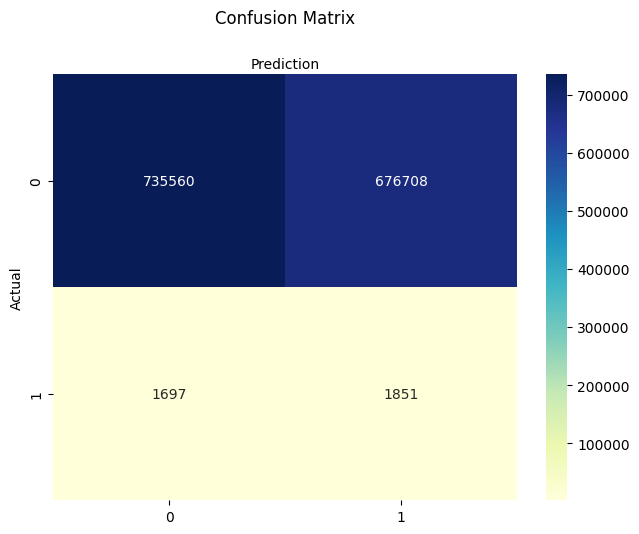

In [ ]:
y_pred = model.predict(X_val)
confusion = metrics.confusion_matrix(diverted_val, y_pred)
training_metrics = {'Training Accuracy': model.score(X_train_diverted, diverted_train),
                    'Validation Accuracy': model.score(X_val, diverted_val),
                    'Precision': metrics.precision_score(diverted_val, y_pred),
                    'Recall': metrics.recall_score(diverted_val, y_pred),
                    'F1 Score': metrics.f1_score(diverted_val, y_pred)}

print('MODEL: {:.3f}'.format(model.intercept_[0]), end='')
coefficients = model.coef_[0]
for i in range(len(coefficients)):
  if coefficients[i] > 0:
    print(' + {:.3f} * x_{}'.format(abs(coefficients[i]), i + 1), end='')
  elif coefficients[i] < 0:
    print(' - {:.3f} * x_{}'.format(abs(coefficients[i]), i + 1), end='')
print()

for i in training_metrics:
  print("{}: {}".format(i, training_metrics[i]))
print()

# create heatmap for confusion matrix
# code frome example
classes = [0, 1]
fig, ax = plt.subplots()
ticks = np.arange(len(classes))
plt.xticks(ticks, classes)
plt.yticks(ticks, classes)
sns.heatmap(pd.DataFrame(confusion), annot=True, cmap="YlGnBu", fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion Matrix', y=1.1)
plt.xlabel('Prediction')
plt.ylabel('Actual')

#### Support vector machine classifier

In [ ]:
model = SVC(kernel='linear', class_weight='balanced')
model.fit(X_train_diverted, diverted_train)

SVC(class_weight='balanced', kernel='linear')

MODEL: -0.058 - 0.216 * x_1 - 0.479 * x_2 - 0.003 * x_3 - 0.143 * x_4 - 0.088 * x_5
Training Accuracy: 0.4551971326164875
Validation Accuracy: 0.5575830475146488
Precision: 0.0027194090435121417
Recall: 0.47998872604284104
F1 Score: 0.0054081776854714375



Text(50.722222222222214, 0.5, 'Actual')

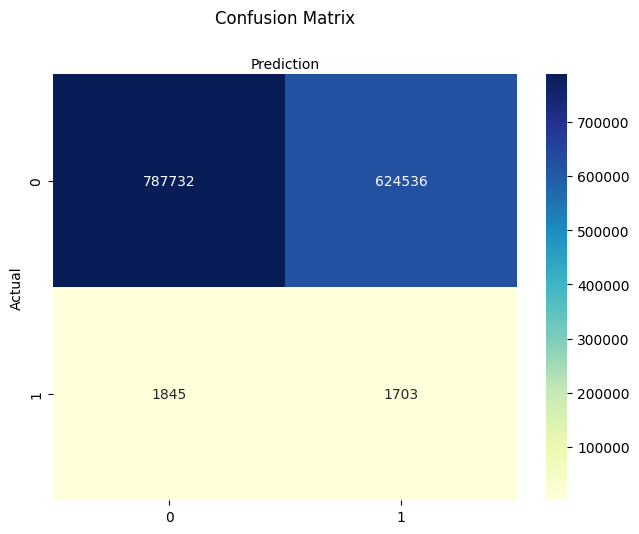

In [ ]:
y_pred = model.predict(X_val)
confusion = metrics.confusion_matrix(diverted_val, y_pred)
training_metrics = {'Training Accuracy': model.score(X_train_diverted_svm, diverted_train_svm),
                    'Validation Accuracy': model.score(X_val, diverted_val),
                    'Precision': metrics.precision_score(diverted_val, y_pred),
                    'Recall': metrics.recall_score(diverted_val, y_pred),
                    'F1 Score': metrics.f1_score(diverted_val, y_pred)}

if model.kernel == 'linear':
  print('MODEL: {:.3f}'.format(model.intercept_[0]), end='')
  coefficients = model.coef_[0]
  for i in range(len(coefficients)):
    if coefficients[i] > 0:
      print(' + {:.3f} * x_{}'.format(abs(coefficients[i]), i + 1), end='')
    elif coefficients[i] < 0:
      print(' - {:.3f} * x_{}'.format(abs(coefficients[i]), i + 1), end='')
  print()

for i in training_metrics:
  print("{}: {}".format(i, training_metrics[i]))
print()

# create heatmap for confusion matrix
# code from example
classes = [0, 1]
fig, ax = plt.subplots()
ticks = np.arange(len(classes))
plt.xticks(ticks, classes)
plt.yticks(ticks, classes)
sns.heatmap(pd.DataFrame(confusion), annot=True, cmap="YlGnBu", fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion Matrix', y=1.1)
plt.xlabel('Prediction')
plt.ylabel('Actual')

#### FCNN classifier

2025-12-07 01:36:22.654739 Epoch 1: training loss 0.7025, validation loss 0.8398
Accuracy: 0.002516569949767484
Precision: 0.002516569949767484
Recall: 1.0
F1 Score: 0.0050205054463959235

2025-12-07 01:36:24.011849 Epoch 2: training loss 0.6976, validation loss 0.7933
Accuracy: 0.002516569949767484
Precision: 0.002516569949767484
Recall: 1.0
F1 Score: 0.0050205054463959235

2025-12-07 01:36:25.729885 Epoch 3: training loss 0.6952, validation loss 0.7617
Accuracy: 0.002516569949767484
Precision: 0.002516569949767484
Recall: 1.0
F1 Score: 0.0050205054463959235

2025-12-07 01:36:26.790577 Epoch 4: training loss 0.6940, validation loss 0.7402
Accuracy: 0.002516569949767484
Precision: 0.002516569949767484
Recall: 1.0
F1 Score: 0.0050205054463959235

2025-12-07 01:36:27.722462 Epoch 5: training loss 0.6933, validation loss 0.7255
Accuracy: 0.003637054532509874
Precision: 0.002517320786506479
Recall: 0.9946674150996352
F1 Score: 0.005021931984279539

2025-12-07 01:36:28.649431 Epoch 6: train

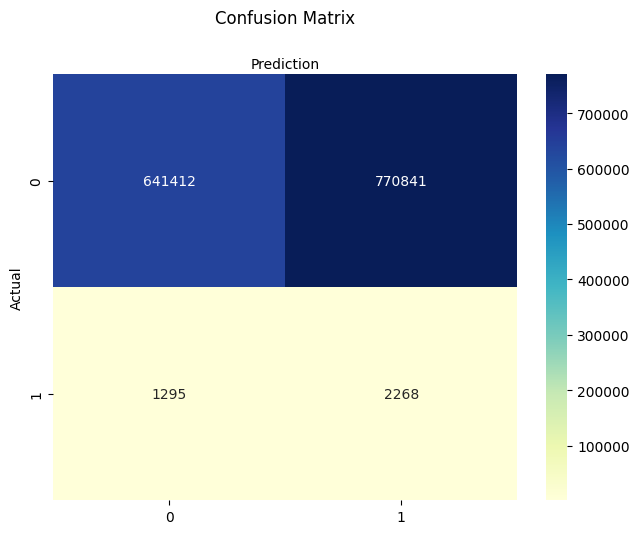

In [ ]:
# LogSoftmax binary classifier
# known good configuration
seq_model = nn.Sequential(nn.Linear(5,1024), nn.Tanh(),
                          nn.Linear(1024,512), nn.Tanh(),
                          nn.Linear(512,64), nn.Tanh(),
                          nn.Linear(64,16), nn.Tanh(),
                          nn.Linear(16,4), nn.Tanh(),
                          nn.Linear(4,2), nn.Tanh(),
                          nn.LogSoftmax(dim=1)).to(device)

optimizer = optim.SGD(seq_model.parameters(), lr=4e-1)

loss_train, loss_val = model_train_classify(
    n_epochs=200,
    optimizer=optimizer,
    model=seq_model,
    loss_fn=nn.NLLLoss(),
    X_train=X_train_diverted.to(device),
    X_val=X_val.to(device),
    y_train=diverted_train.to(device),
    y_val=diverted_val.to(device)
)

Training loss history: [0.70253503 0.69762814 0.69518149 0.69395417 0.69332081 0.69297552
 0.69277072 0.69263637 0.69253838 0.69246101 0.69239628 0.6923402
 0.69229043 0.69224596 0.69220579 0.69216949 0.69213641 0.69210613
 0.69207853 0.6920532  0.69202989 0.69200832 0.69198829 0.69196981
 0.69195241 0.69193608 0.69192076 0.69190633 0.69189256 0.69187945
 0.69186693 0.69185495 0.69184339 0.69183218 0.69182122 0.69181067
 0.69180036 0.69179028 0.69178033 0.69177049 0.69176096 0.69175148
 0.69174212 0.69173282 0.69172364 0.69171447 0.69170541 0.69169635
 0.69168735 0.69167835 0.6916694  0.69166046 0.69165158 0.69164264
 0.69163376 0.69162488 0.69161594 0.691607   0.69159812 0.69158912
 0.69158024 0.69157135 0.69156235 0.69155341 0.69154441 0.69153535
 0.69152635 0.69151729 0.69150829 0.69149917 0.69149005 0.69148088
 0.6914717  0.69146246 0.69145334 0.69144404 0.69143468 0.69142538
 0.69141608 0.69140667 0.69139731 0.69138777 0.6913783  0.6913687
 0.69135916 0.69134957 0.69133997 0.69133

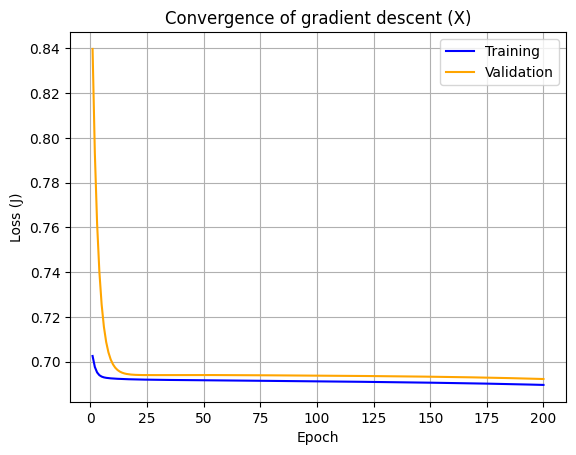

In [ ]:
plot_convergence(loss_train, loss_val)

### Total arrival delay regression

#### Gradient descent regression

2025-12-07 01:41:13.950334 Epoch 1: training loss 3338.2993, validation loss 3439.2717
2025-12-07 01:41:14.044259 Epoch 2: training loss 3306.3855, validation loss 3407.0212
2025-12-07 01:41:14.131532 Epoch 3: training loss 3286.0186, validation loss 3386.3850
2025-12-07 01:41:14.228245 Epoch 4: training loss 3273.0137, validation loss 3373.1655
2025-12-07 01:41:14.315493 Epoch 5: training loss 3264.7070, validation loss 3364.6882
2025-12-07 01:41:14.412595 Epoch 6: training loss 3259.4009, validation loss 3359.2458
2025-12-07 01:41:14.499955 Epoch 7: training loss 3256.0100, validation loss 3355.7461
2025-12-07 01:41:14.602096 Epoch 8: training loss 3253.8430, validation loss 3353.4919
2025-12-07 01:41:14.689446 Epoch 9: training loss 3252.4573, validation loss 3352.0371
2025-12-07 01:41:14.776710 Epoch 10: training loss 3251.5713, validation loss 3351.0962
2025-12-07 01:41:14.886931 Epoch 11: training loss 3251.0046, validation loss 3350.4854
2025-12-07 01:41:15.013264 Epoch 12: trai

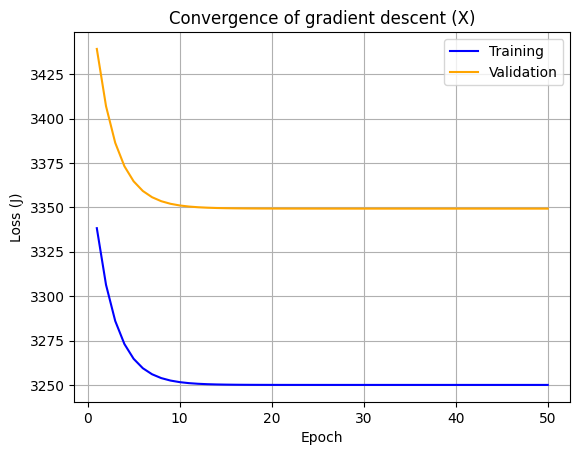

In [ ]:
# train model with vanilla GD
params = torch.tensor([0.0, 0.0, 0.0, 0.0, 0.0, 0.0], requires_grad=True)
loss_train, loss_val = model_train_vanilla(
  n_epochs=50,
  learning_rate=1e-1,
  params=params,
  X_train=torch.tensor(np.hstack((np.ones((len(X_train),1)),
                                  X_train.numpy())), dtype=torch.float32),
  X_val=torch.tensor(np.hstack((np.ones((len(X_val),1)),
                                X_val.numpy())), dtype=torch.float32),
  y_train=arr_delay_train,
  y_val=arr_delay_val
)
plot_convergence(loss_train, loss_val)

#### Support vector regression

In [ ]:
model = SVR(kernel='rbf', C=1)
model.fit(X_train_svm.numpy(), arr_delay_train_svm.numpy())

In [ ]:
support vector regression measures fit quality with R^2 score
y_train_pred = model.predict(X_train_svm)
y_val_pred = model.predict(X_val)

sq_err = np.square(np.subtract(y_train_pred, arr_delay_train))
J_train = (1 / (2 * len(X_train))) * np.sum(sq_err)
sq_err = np.square(np.subtract(y_val_pred, arr_delay_val))
J_val = (1 / (2 * len(X_val))) * np.sum(sq_err)

training_metrics = {'Training R^2': model.score(X_train, arr_delay_train),
                    'Validation R^2': model.score(X_val, arr_delay_val),
                    'Training Loss': J_train,
                    'Validation Loss': J_val}

print('MODEL: {:.3f}'.format(model.intercept_[0]), end='')
coefficients = model.coef_[0]
for i in range(len(coefficients)):
  if coefficients[i] > 0:
    print(' + {:.3f} * x_{}'.format(abs(coefficients[i]), i + 1), end='')
  elif coefficients[i] < 0:
    print(' - {:.3f} * x_{}'.format(abs(coefficients[i]), i + 1), end='')
print()

for i in training_metrics:
  print("{}: {}".format(i, training_metrics[i]))
print()

#### FCNN regression

In [ ]:
seq_model = nn.Sequential(nn.Linear(5,2048), nn.Tanh(),
                          nn.Linear(2048,512), nn.Tanh(),
                          nn.Linear(512,256), nn.Tanh(),
                          nn.Linear(256,256), nn.Tanh(),
                          nn.Linear(256,256), nn.Tanh(),
                          nn.Linear(256,64), nn.Tanh(),
                          nn.Linear(64,32), nn.Tanh(),
                          nn.Linear(32,4), nn.Tanh(),
                          nn.Linear(4,1)).to(device)

optimizer = optim.SGD(seq_model.parameters(), lr=1e-3)

loss_train, loss_val = model_train_regression(
    n_epochs=200,
    optimizer=optimizer,
    model=seq_model,
    loss_fn=nn.MSELoss(),
    X_train=X_train.to(device),
    X_val=X_val.to(device),
    y_train=arr_delay_train.to(device),
    y_val=arr_delay_val.to(device)
)

2025-12-07 01:47:39.453500 Epoch 1: training loss 3606.3408, validation loss 3734.5190
2025-12-07 01:47:40.126791 Epoch 2: training loss 2720.0244, validation loss 3640.8237
2025-12-07 01:47:40.697766 Epoch 3: training loss 2869.2585, validation loss 3005.6406
2025-12-07 01:47:41.312142 Epoch 4: training loss 2870.7344, validation loss 3442.7102
2025-12-07 01:47:42.052115 Epoch 5: training loss 4544.6938, validation loss 3130.9185
2025-12-07 01:47:42.562812 Epoch 6: training loss 2976.1384, validation loss 5264.6987
2025-12-07 01:47:42.868214 Epoch 7: training loss 3305.2036, validation loss 3659.9397
2025-12-07 01:47:43.155784 Epoch 8: training loss 2704.0867, validation loss 3379.3730
2025-12-07 01:47:43.488561 Epoch 9: training loss 3058.8457, validation loss 3550.7959
2025-12-07 01:47:43.924416 Epoch 10: training loss 2973.5276, validation loss 4126.4717
2025-12-07 01:47:44.333632 Epoch 11: training loss 2752.4993, validation loss 3446.2405
2025-12-07 01:47:44.800065 Epoch 12: trai

Training loss history: [3606.34082031 2720.02441406 2869.25854492 2870.734375   4544.69384766
 2976.13842773 3305.20361328 2704.08666992 3058.84570312 2973.52758789
 2752.49926758 3056.11572266 3267.87402344 2683.66357422 3844.3449707
 3357.26635742 3044.95654297 3546.15625    3297.36132812 3645.74072266
 3037.82568359 3241.40014648 3059.13452148 2711.14135742 3051.07128906
 4033.37060547 3278.12719727 3111.5300293  2906.44921875 3119.83251953
 3659.67895508 3212.79956055 4071.7890625  3952.97753906 3402.3918457
 3491.42260742 2853.44750977 3038.84790039 3668.93066406 3335.78662109
 3267.00048828 2842.56103516 2722.2434082  2812.64990234 3129.32983398
 3448.09765625 3410.9987793  3306.8293457  2855.79077148 2931.14208984
 4061.87670898 2971.27148438 3053.40551758 3553.81542969 3388.09643555
 4880.80859375 2897.81176758 3339.26196289 3672.05737305 3307.31103516
 2890.64526367 2997.05688477 3409.90625    3050.31567383 3393.97045898
 3348.27954102 2844.23779297 2997.03857422 2785.35546875

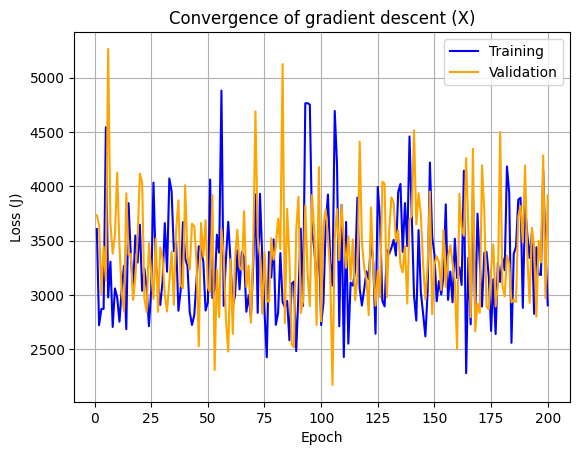

In [ ]:
plot_convergence(loss_train, loss_val)

### Carrier delay regression

#### Gradient descent regression

2025-12-07 01:49:24.605691 Epoch 1: training loss 1289.1134, validation loss 1353.6896
2025-12-07 01:49:24.747399 Epoch 2: training loss 1279.3680, validation loss 1343.8350
2025-12-07 01:49:24.919589 Epoch 3: training loss 1273.2479, validation loss 1337.6294
2025-12-07 01:49:25.027593 Epoch 4: training loss 1269.2123, validation loss 1333.5232
2025-12-07 01:49:25.126505 Epoch 5: training loss 1266.6346, validation loss 1330.8895
2025-12-07 01:49:25.287938 Epoch 6: training loss 1264.9878, validation loss 1329.1981
2025-12-07 01:49:25.452173 Epoch 7: training loss 1263.9344, validation loss 1328.1089
2025-12-07 01:49:25.571721 Epoch 8: training loss 1263.2604, validation loss 1327.4066
2025-12-07 01:49:25.680502 Epoch 9: training loss 1262.8295, validation loss 1326.9528
2025-12-07 01:49:25.792662 Epoch 10: training loss 1262.5538, validation loss 1326.6591
2025-12-07 01:49:25.905784 Epoch 11: training loss 1262.3772, validation loss 1326.4680
2025-12-07 01:49:26.032209 Epoch 12: trai

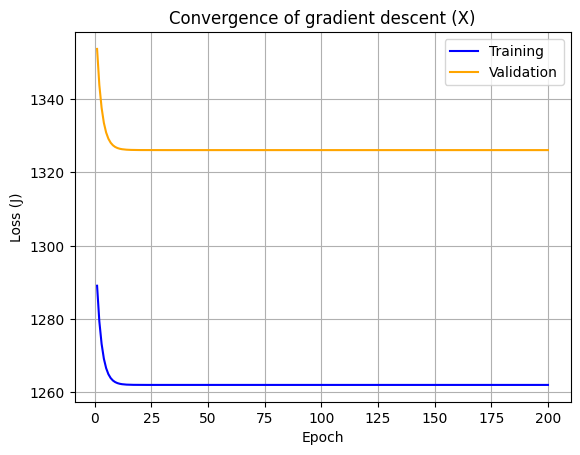

In [ ]:
# train model with vanilla GD
params = torch.tensor([0.0, 0.0, 0.0, 0.0, 0.0, 0.0], requires_grad=True)
loss_train, loss_val = model_train_vanilla(
  n_epochs=200,
  learning_rate=1e-1,
  params=params,
  X_train=torch.tensor(np.hstack((np.ones((len(X_train),1)),
                                  X_train.numpy())), dtype=torch.float32),
  X_val=torch.tensor(np.hstack((np.ones((len(X_val),1)),
                                X_val.numpy())), dtype=torch.float32),
  y_train=carrier_delay_train,
  y_val=carrier_delay_val
)
plot_convergence(loss_train, loss_val)

#### Support vector regression

In [ ]:
# model = SVR(kernel='rbf', C=1)
# model.fit(X_train.cpu().numpy(), arr_delay_train.cpu().numpy())

In [ ]:
# support vector regression measures fit quality with R^2 score
# y_train_pred = model.predict(X_train)
# y_val_pred = model.predict(X_val)

# sq_err = np.square(np.subtract(y_train_pred, arr_delay_train))
# J_train = (1 / (2 * len(X_train))) * np.sum(sq_err)
# sq_err = np.square(np.subtract(y_val_pred, arr_delay_val))
# J_val = (1 / (2 * len(X_val))) * np.sum(sq_err)

# training_metrics = {'Training R^2': model.score(X_train, arr_delay_train),
#                     'Validation R^2': model.score(X_val, arr_delay_val),
#                     'Training Loss': J_train,
#                     'Validation Loss': J_val}

# print('MODEL: {:.3f}'.format(model.intercept_[0]), end='')
# coefficients = model.coef_[0]
# for i in range(len(coefficients)):
#   if coefficients[i] > 0:
#     print(' + {:.3f} * x_{}'.format(abs(coefficients[i]), i + 1), end='')
#   elif coefficients[i] < 0:
#     print(' - {:.3f} * x_{}'.format(abs(coefficients[i]), i + 1), end='')
# print()

# for i in training_metrics:
#   print("{}: {}".format(i, training_metrics[i]))
# print()

#### FCNN regression

In [ ]:
seq_model = nn.Sequential(nn.Linear(5,32), nn.Tanh(),
                          nn.Linear(32,4), nn.Tanh(),
                          nn.Linear(4,1)).to(device)

optimizer = optim.SGD(seq_model.parameters(), lr=1e-1)

loss_train, loss_val = model_train_regression(
    n_epochs=200,
    optimizer=optimizer,
    model=seq_model,
    loss_fn=nn.MSELoss(),
    X_train=X_train.to(device),
    X_val=X_val.to(device),
    y_train=carrier_delay_train.to(device),
    y_val=carrier_delay_val.to(device)
)

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/loss.py:634: UserWarning: Using a target size (torch.Size([10000])) that is different to the input size (torch.Size([10000, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


2025-12-07 01:51:27.959518 Epoch 1: training loss 754.2723, validation loss 1265.6655
2025-12-07 01:51:28.654648 Epoch 2: training loss 1771.4583, validation loss 805.8664
2025-12-07 01:51:29.343521 Epoch 3: training loss 2005.1434, validation loss 798.4733
2025-12-07 01:51:29.965742 Epoch 4: training loss 1588.1665, validation loss 1751.4017
2025-12-07 01:51:30.909230 Epoch 5: training loss 1419.8264, validation loss 1272.9568
2025-12-07 01:51:31.454218 Epoch 6: training loss 811.3534, validation loss 1453.1599
2025-12-07 01:51:31.958368 Epoch 7: training loss 812.0817, validation loss 2185.9399
2025-12-07 01:51:32.470001 Epoch 8: training loss 848.1376, validation loss 1106.5031
2025-12-07 01:51:32.725556 Epoch 9: training loss 1322.4313, validation loss 1326.1450
2025-12-07 01:51:32.989987 Epoch 10: training loss 1168.5269, validation loss 2100.9263
2025-12-07 01:51:33.251794 Epoch 11: training loss 974.9326, validation loss 1045.2831
2025-12-07 01:51:33.528798 Epoch 12: training lo

Training loss history: [1289.11340332 1279.36804199 1273.2479248  1269.21228027 1266.63464355
 1264.98779297 1263.93444824 1263.26037598 1262.82946777 1262.55383301
 1262.37719727 1262.2644043  1262.19226074 1262.14611816 1262.11657715
 1262.09765625 1262.08557129 1262.07775879 1262.07275391 1262.06970215
 1262.06750488 1262.06628418 1262.06555176 1262.06494141 1262.06469727
 1262.06445312 1262.06420898 1262.06420898 1262.06408691 1262.06408691
 1262.06396484 1262.06396484 1262.06408691 1262.06408691 1262.06396484
 1262.06396484 1262.06396484 1262.06396484 1262.06396484 1262.06396484
 1262.06384277 1262.06396484 1262.06396484 1262.06396484 1262.06396484
 1262.06396484 1262.06396484 1262.06384277 1262.06384277 1262.06384277
 1262.06408691 1262.06396484 1262.06408691 1262.06396484 1262.06408691
 1262.06384277 1262.06384277 1262.06384277 1262.06396484 1262.06408691
 1262.06384277 1262.06408691 1262.06384277 1262.06384277 1262.06384277
 1262.06384277 1262.06408691 1262.06384277 1262.063842

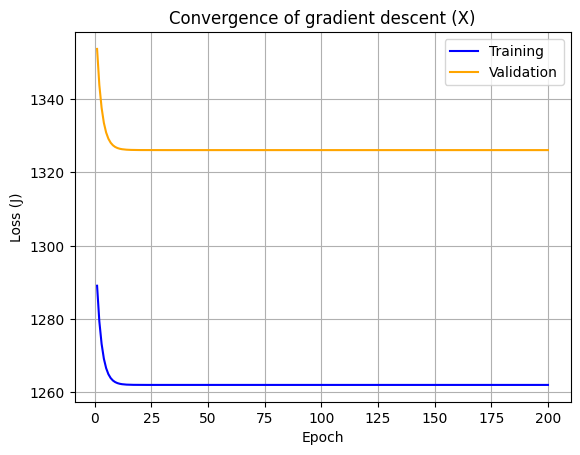

In [ ]:
plot_convergence(loss_train, loss_val)

### Late aircraft delay regression

#### Gradient descent regression

2025-12-07 01:52:53.440122 Epoch 1: training loss 995.0408, validation loss 1019.6569
2025-12-07 01:52:53.549421 Epoch 2: training loss 993.2375, validation loss 1017.8439
2025-12-07 01:52:53.655612 Epoch 3: training loss 991.4839, validation loss 1016.0809
2025-12-07 01:52:53.753586 Epoch 4: training loss 989.7896, validation loss 1014.3776
2025-12-07 01:52:53.857690 Epoch 5: training loss 988.1583, validation loss 1012.7370
2025-12-07 01:52:53.966708 Epoch 6: training loss 986.5953, validation loss 1011.1649
2025-12-07 01:52:54.069576 Epoch 7: training loss 985.0983, validation loss 1009.6592
2025-12-07 01:52:54.186997 Epoch 8: training loss 983.6655, validation loss 1008.2178
2025-12-07 01:52:54.304872 Epoch 9: training loss 982.2947, validation loss 1006.8386
2025-12-07 01:52:54.436361 Epoch 10: training loss 980.9828, validation loss 1005.5186
2025-12-07 01:52:54.545219 Epoch 11: training loss 979.7271, validation loss 1004.2549
2025-12-07 01:52:54.654148 Epoch 12: training loss 9

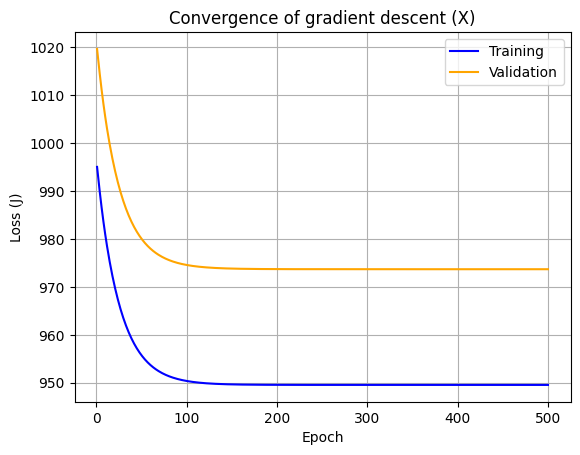

In [ ]:
# train model with vanilla GD
params = torch.tensor([0.0, 0.0, 0.0, 0.0, 0.0, 0.0], requires_grad=True)
loss_train, loss_val = model_train_vanilla(
  n_epochs=500,
  learning_rate=1e-2,
  params=params,
  X_train=torch.tensor(np.hstack((np.ones((len(X_train),1)),
                                  X_train.numpy())), dtype=torch.float32),
  X_val=torch.tensor(np.hstack((np.ones((len(X_val),1)),
                                X_val.numpy())), dtype=torch.float32),
  y_train=late_aircraft_delay_train,
  y_val=late_aircraft_delay_val
)
plot_convergence(loss_train, loss_val)

#### Support vector regression

In [ ]:
# model = SVR(kernel='rbf', C=1)
# model.fit(X_train.cpu().numpy(), arr_delay_train.cpu().numpy())

In [ ]:
# support vector regression measures fit quality with R^2 score
# y_train_pred = model.predict(X_train)
# y_val_pred = model.predict(X_val)

# sq_err = np.square(np.subtract(y_train_pred, arr_delay_train))
# J_train = (1 / (2 * len(X_train))) * np.sum(sq_err)
# sq_err = np.square(np.subtract(y_val_pred, arr_delay_val))
# J_val = (1 / (2 * len(X_val))) * np.sum(sq_err)

# training_metrics = {'Training R^2': model.score(X_train, arr_delay_train),
#                     'Validation R^2': model.score(X_val, arr_delay_val),
#                     'Training Loss': J_train,
#                     'Validation Loss': J_val}

# print('MODEL: {:.3f}'.format(model.intercept_[0]), end='')
# coefficients = model.coef_[0]
# for i in range(len(coefficients)):
#   if coefficients[i] > 0:
#     print(' + {:.3f} * x_{}'.format(abs(coefficients[i]), i + 1), end='')
#   elif coefficients[i] < 0:
#     print(' - {:.3f} * x_{}'.format(abs(coefficients[i]), i + 1), end='')
# print()

# for i in training_metrics:
#   print("{}: {}".format(i, training_metrics[i]))
# print()

#### FCNN regression

In [ ]:
seq_model = nn.Sequential(nn.Linear(5,1024), nn.Tanh(),
                          nn.Linear(1024,256), nn.Tanh(),
                          nn.Linear(256,32), nn.Tanh(),
                          nn.Linear(32,4), nn.Tanh(),
                          nn.Linear(4,1)).to(device)

optimizer = optim.SGD(seq_model.parameters(), lr=1e-2)

loss_train, loss_val = model_train_regression(
    n_epochs=200,
    optimizer=optimizer,
    model=seq_model,
    loss_fn=nn.MSELoss(),
    X_train=X_train.to(device),
    X_val=X_val.to(device),
    y_train=late_aircraft_delay_train.to(device),
    y_val=late_aircraft_delay_val.to(device)
)

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/loss.py:634: UserWarning: Using a target size (torch.Size([10000])) that is different to the input size (torch.Size([10000, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


2025-12-07 01:54:54.479225 Epoch 1: training loss 693.4457, validation loss 933.4941
2025-12-07 01:54:55.117998 Epoch 2: training loss 845.3074, validation loss 997.7994
2025-12-07 01:54:55.582166 Epoch 3: training loss 1354.7382, validation loss 815.7479
2025-12-07 01:54:55.926330 Epoch 4: training loss 1078.1365, validation loss 1049.9657
2025-12-07 01:54:56.266191 Epoch 5: training loss 971.2810, validation loss 816.5273
2025-12-07 01:54:56.598970 Epoch 6: training loss 1009.6492, validation loss 1244.0353
2025-12-07 01:54:56.935905 Epoch 7: training loss 802.2388, validation loss 979.2699
2025-12-07 01:54:57.270846 Epoch 8: training loss 1088.0067, validation loss 712.9189
2025-12-07 01:54:57.584209 Epoch 9: training loss 1089.6309, validation loss 860.8679
2025-12-07 01:54:57.877094 Epoch 10: training loss 978.9047, validation loss 1243.5151
2025-12-07 01:54:58.181594 Epoch 11: training loss 720.0100, validation loss 898.0696
2025-12-07 01:54:58.444621 Epoch 12: training loss 1123

Training loss history: [ 693.44573975  845.30743408 1354.73815918 1078.13647461  971.28100586
 1009.64923096  802.23876953 1088.00671387 1089.63085938  978.90466309
  720.01000977 1123.47338867  771.84729004 1322.97668457  969.43127441
 1098.70495605 1130.44750977 1199.70031738 1025.35876465  838.21166992
  907.41931152 1165.46716309 1071.08032227  774.50823975  846.63189697
  769.01794434  946.95562744  687.14251709 1253.98535156 1305.19677734
  934.84301758 1043.88146973 1112.59118652 1229.88134766  908.81671143
  992.65759277  918.62860107 1072.09960938  915.40203857  955.07641602
 1143.16003418 1022.66363525  741.95697021 1425.14941406  800.574646
  708.48931885  801.61773682  884.99591064  902.64941406 1000.13970947
  910.00537109  851.59533691  864.21765137 1024.9276123   730.00524902
  960.67602539  752.45916748  842.39587402 1062.78942871 1474.98364258
  781.99310303  759.72845459 1322.94873047 1152.21154785  875.85046387
  773.17059326 1068.53881836  871.11407471  874.2878418 

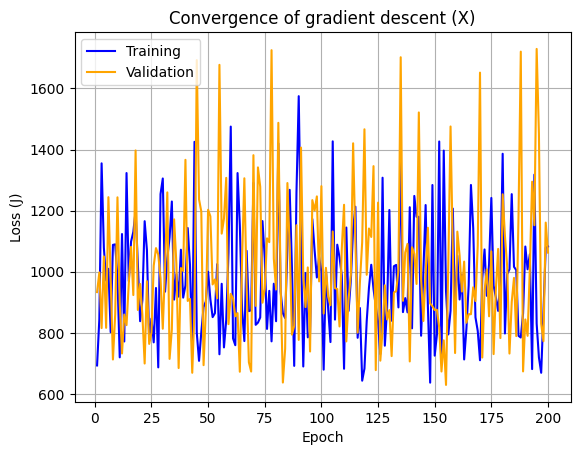

In [ ]:
plot_convergence(loss_train, loss_val)

## Design iterations

First, a change to month-by-month data. The data below is just for the month of January.

In [12]:
# change design to splitting month-by-month rather than doing the whole thing
# at once, testing with just January to start
flight_inputs = df[['year', 'month', 'day_of_month', 'day_of_week',
                    'op_unique_carrier', 'origin', 'dest', 'crs_dep_time',
                    'crs_arr_time', 'crs_elapsed_time', 'diverted', 'arr_delay',
                    'carrier_delay', 'late_aircraft_delay']]
flight_inputs

,year,month,day_of_month,day_of_week,op_unique_carrier,origin,dest,crs_dep_time,crs_arr_time,crs_elapsed_time,diverted,arr_delay,carrier_delay,late_aircraft_delay
0,2024,1,1,1,9E,JFK,DTW,1252,1508,136.0,0,-19.0,0,0
1,2024,1,1,1,9E,MSP,CLE,1015,1325,130.0,0,-30.0,0,0
2,2024,1,1,1,9E,JFK,RIC,1415,1601,106.0,0,-20.0,0,0
3,2024,1,1,1,9E,RIC,JFK,1650,1841,111.0,0,-42.0,0,0
4,2024,1,1,1,9E,DTW,MKE,1015,1034,79.0,0,-14.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7079076,2024,12,31,2,YX,MYR,LGA,1226,1423,117.0,0,-21.0,0,0
7079077,2024,12,31,2,YX,JFK,PWM,950,1119,89.0,0,-28.0,0,0
7079078,2024,12,31,2,YX,PWM,JFK,1200,1329,89.0,0,-13.0,0,0
7079079,2024,12,31,2,YX,JFK,SYR,1530,1659,89.0,0,-14.0,0,0


In [13]:
# clean data again
flight_inputs.pop('year')
flight_inputs['op_unique_carrier'] = pd.Categorical(flight_inputs['op_unique_carrier']).codes
flight_inputs['origin'] = pd.Categorical(flight_inputs['origin']).codes
flight_inputs['dest'] = pd.Categorical(flight_inputs['dest']).codes
flight_inputs = flight_inputs.astype(np.float32)

delay_label_cols = ['arr_delay', 'carrier_delay', 'late_aircraft_delay']
flight_inputs[delay_label_cols] = flight_inputs[delay_label_cols].fillna(0)

month_data = flight_inputs[flight_inputs['month'] == 1]
month_data.pop('month')
diverted = month_data.pop('diverted').to_numpy()
arr_delay = month_data.pop('arr_delay').to_numpy()
carrier_delay = month_data.pop('carrier_delay').to_numpy()
late_aircraft_delay = month_data.pop('late_aircraft_delay').to_numpy()

X = torch.tensor(month_data.to_numpy(), dtype=torch.float32)
diverted = torch.tensor(diverted, dtype=torch.long)
arr_delay = torch.tensor(arr_delay, dtype=torch.float32)
carrier_delay = torch.tensor(carrier_delay, dtype=torch.float32)
late_aircraft_delay = torch.tensor(late_aircraft_delay, dtype=torch.float32)

n = X.shape[0]
n_val = int(0.2 * n)
n_train_svm = int(0.1 * n)

shuffled_indices = torch.randperm(n)
train_indices = shuffled_indices[:-n_val]
train_indices_svm = shuffled_indices[:n_train_svm]
val_indices = shuffled_indices[-n_val:]

X_train = X[train_indices]
X_train_svm = X[train_indices_svm]
X_val = X[val_indices]

diverted_train = diverted[train_indices]
diverted_train_svm = diverted[train_indices_svm]
diverted_val = diverted[val_indices]
arr_delay_train = arr_delay[train_indices]
arr_delay_train_svm = arr_delay[train_indices_svm]
arr_delay_val = arr_delay[val_indices]
carrier_delay_train = carrier_delay[train_indices]
carrier_delay_train_svm = carrier_delay[train_indices_svm]
carrier_delay_val = carrier_delay[val_indices]
late_aircraft_delay_train = late_aircraft_delay[train_indices]
late_aircraft_delay_train_svm = late_aircraft_delay[train_indices_svm]
late_aircraft_delay_val = late_aircraft_delay[val_indices]

# standardize input features
for col in range(X_train.shape[1]):
  mu = torch.mean(X_train[:, col])
  sigma = torch.std(X_train[:, col])
  X_train[:, col] = (X_train[:, col] - mu) / sigma
  X_train_svm[:, col] = (X_train_svm[:, col] - mu) / sigma
  X_val[:, col] = (X_val[:, col] - mu) / sigma

/tmp/ipython-input-2023447160.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flight_inputs['op_unique_carrier'] = pd.Categorical(flight_inputs['op_unique_carrier']).codes
/tmp/ipython-input-2023447160.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flight_inputs['origin'] = pd.Categorical(flight_inputs['origin']).codes
/tmp/ipython-input-2023447160.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

### Diverted flight classifier

#### Logistic regression gradient descent

In [16]:
# undersampling of positive class to enhance sensitivity
indices_negative = []
indices_positive = []

for i in range(len(diverted_train)):
  if diverted_train[i] == 1:
    indices_positive.append(i)

for i in range(len(diverted_train)):
  if diverted_train[i] == 0:
    indices_negative.append(i)
  if len(indices_negative) >= len(indices_positive):
    break

In [17]:
indices = indices_positive + indices_negative
X_train_diverted = X_train[indices]
X_train_diverted_svm = X_train[:int(len(indices_negative)*0.1)]
diverted_train = diverted_train[indices]
diverted_train_svm = diverted_train[:int(len(indices_negative)*0.1)]

In [ ]:
# train model with SciKit Learn
# note: it is not possible to probe loss with SKLearn
model = LogisticRegression(random_state=0)
model.fit(X_train_diverted, diverted_train)

LogisticRegression(random_state=0)

MODEL: -0.101 - 0.072 * x_1 - 0.206 * x_2 - 0.096 * x_3 - 0.027 * x_4 - 0.177 * x_5 - 0.026 * x_6 + 0.023 * x_7 + 0.360 * x_8
Training Accuracy: 0.5959132610508757
Validation Accuracy: 0.6183967694191167
Precision: 0.004423191870890616
Recall: 0.5910543130990416
F1 Score: 0.008780673026721723



Text(50.722222222222214, 0.5, 'Actual')

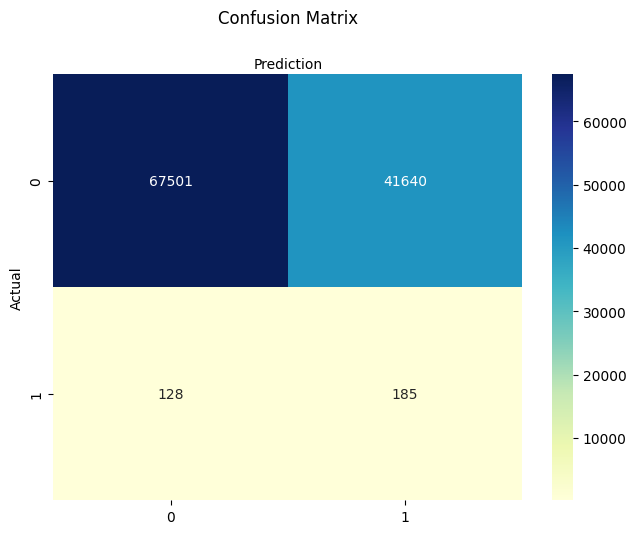

In [ ]:
y_pred = model.predict(X_val)
confusion = metrics.confusion_matrix(diverted_val, y_pred)
training_metrics = {'Training Accuracy': model.score(X_train_diverted, diverted_train),
                    'Validation Accuracy': model.score(X_val, diverted_val),
                    'Precision': metrics.precision_score(diverted_val, y_pred),
                    'Recall': metrics.recall_score(diverted_val, y_pred),
                    'F1 Score': metrics.f1_score(diverted_val, y_pred)}

print('MODEL: {:.3f}'.format(model.intercept_[0]), end='')
coefficients = model.coef_[0]
for i in range(len(coefficients)):
  if coefficients[i] > 0:
    print(' + {:.3f} * x_{}'.format(abs(coefficients[i]), i + 1), end='')
  elif coefficients[i] < 0:
    print(' - {:.3f} * x_{}'.format(abs(coefficients[i]), i + 1), end='')
print()

for i in training_metrics:
  print("{}: {}".format(i, training_metrics[i]))
print()

# create heatmap for confusion matrix
# code frome example
classes = [0, 1]
fig, ax = plt.subplots()
ticks = np.arange(len(classes))
plt.xticks(ticks, classes)
plt.yticks(ticks, classes)
sns.heatmap(pd.DataFrame(confusion), annot=True, cmap="YlGnBu", fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion Matrix', y=1.1)
plt.xlabel('Prediction')
plt.ylabel('Actual')

#### Support vector machine classifier

In [ ]:
model = SVC(kernel='linear', class_weight='balanced', C=100)
model.fit(X_train_diverted, diverted_train)

SVC(C=100, class_weight='balanced', kernel='linear')

MODEL: -0.221 - 0.178 * x_1 - 0.305 * x_2 - 0.140 * x_3 - 0.050 * x_4 - 0.322 * x_5 + 0.005 * x_6 + 0.024 * x_7 + 0.521 * x_8
Training Accuracy: 0.42016806722689076
Validation Accuracy: 0.6440696548321669
Precision: 0.004640192785910221
Recall: 0.5782747603833865
F1 Score: 0.009206510681586979



Text(50.722222222222214, 0.5, 'Actual')

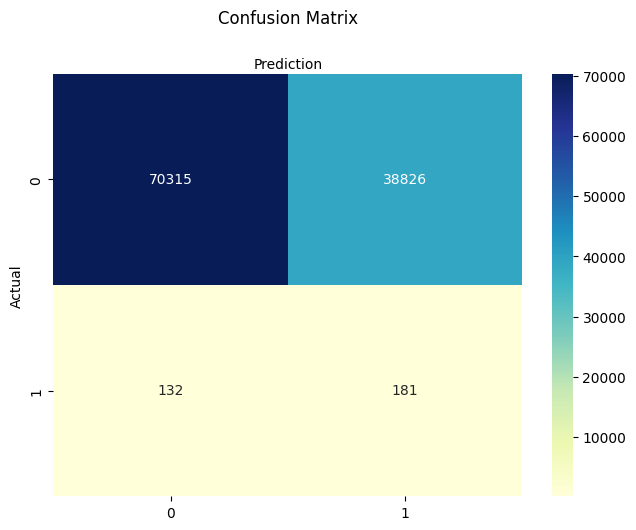

In [ ]:
y_pred = model.predict(X_val)
confusion = metrics.confusion_matrix(diverted_val, y_pred)
training_metrics = {'Training Accuracy': model.score(X_train_diverted_svm, diverted_train_svm),
                    'Validation Accuracy': model.score(X_val, diverted_val),
                    'Precision': metrics.precision_score(diverted_val, y_pred),
                    'Recall': metrics.recall_score(diverted_val, y_pred),
                    'F1 Score': metrics.f1_score(diverted_val, y_pred)}

if model.kernel == 'linear':
  print('MODEL: {:.3f}'.format(model.intercept_[0]), end='')
  coefficients = model.coef_[0]
  for i in range(len(coefficients)):
    if coefficients[i] > 0:
      print(' + {:.3f} * x_{}'.format(abs(coefficients[i]), i + 1), end='')
    elif coefficients[i] < 0:
      print(' - {:.3f} * x_{}'.format(abs(coefficients[i]), i + 1), end='')
  print()

for i in training_metrics:
  print("{}: {}".format(i, training_metrics[i]))
print()

# create heatmap for confusion matrix
# code from example
classes = [0, 1]
fig, ax = plt.subplots()
ticks = np.arange(len(classes))
plt.xticks(ticks, classes)
plt.yticks(ticks, classes)
sns.heatmap(pd.DataFrame(confusion), annot=True, cmap="YlGnBu", fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion Matrix', y=1.1)
plt.xlabel('Prediction')
plt.ylabel('Actual')

#### FCNN classifier

/tmp/ipython-input-3526274791.py:11: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:836.)
  loss_train_history[epoch-1] = loss_train


2025-12-07 20:19:28.045974 Epoch 1: training loss 0.7291, validation loss 0.9981
Accuracy: 0.0027591499625413416
Precision: 0.0027591499625413416
Recall: 1.0
F1 Score: 0.005503116002769781

2025-12-07 20:19:28.180473 Epoch 2: training loss 0.7080, validation loss 0.9159
Accuracy: 0.0027591499625413416
Precision: 0.0027591499625413416
Recall: 1.0
F1 Score: 0.005503116002769781

2025-12-07 20:19:28.312286 Epoch 3: training loss 0.6717, validation loss 0.7558
Accuracy: 0.163109616825333
Precision: 0.003481118905833083
Recall: 0.652317880794702
F1 Score: 0.006925280790255391

2025-12-07 20:19:28.438226 Epoch 4: training loss 0.6638, validation loss 0.7049
Accuracy: 0.3242480859539167
Precision: 0.00529277131413313
Recall: 0.3675496688741722
F1 Score: 0.010435273103318606

2025-12-07 20:19:28.573408 Epoch 5: training loss 0.6647, validation loss 0.7389
Accuracy: 0.4149560545982787
Precision: 0.005028025057698648
Recall: 0.40397350993377484
F1 Score: 0.009932426931531384

2025-12-07 20:19:28

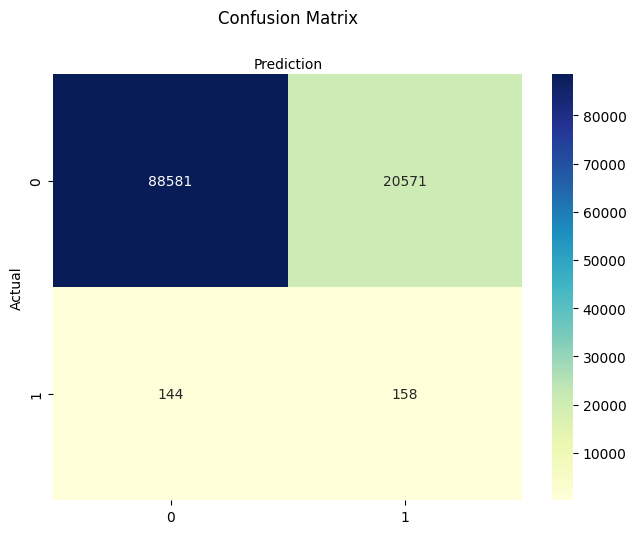

In [18]:
# LogSoftmax binary classifier
# known good configuration
seq_model = nn.Sequential(nn.Linear(8,1024), nn.Tanh(),
                          nn.Linear(1024,512), nn.Tanh(),
                          nn.Linear(512,512), nn.Tanh(),
                          nn.Linear(512,512), nn.Tanh(),
                          nn.Linear(512,512), nn.Tanh(),
                          nn.Linear(512,512), nn.Tanh(),
                          nn.Linear(512,64), nn.Tanh(),
                          nn.Linear(64,16), nn.Tanh(),
                          nn.Linear(16,4), nn.Tanh(),
                          nn.Linear(4,2), nn.Tanh(),
                          nn.LogSoftmax(dim=1)).to(device)

optimizer = optim.Adam(seq_model.parameters(), lr=1e-3)

loss_train, loss_val = model_train_classify(
    n_epochs=125,
    optimizer=optimizer,
    model=seq_model,
    loss_fn=nn.NLLLoss(),
    X_train=X_train_diverted.to(device),
    X_val=X_val.to(device),
    y_train=diverted_train.to(device),
    y_val=diverted_val.to(device)
)

Training loss history: [0.7291044  0.70800531 0.67165381 0.66376841 0.66469622 0.66279155
 0.66901845 0.67032778 0.66420311 0.6637404  0.66014922 0.66000605
 0.66274804 0.66071653 0.6611858  0.65857017 0.65872079 0.65806448
 0.65849316 0.65851969 0.65927553 0.65663153 0.65684336 0.65684694
 0.656973   0.6556899  0.65616959 0.65519828 0.65453374 0.65355337
 0.65353543 0.65385222 0.65283847 0.65250385 0.65240264 0.65196407
 0.6515941  0.65166569 0.6510781  0.65064007 0.65049112 0.65232772
 0.651963   0.6514141  0.65081626 0.65155089 0.65173268 0.65072817
 0.64914012 0.64851791 0.6491434  0.64776057 0.64650637 0.64710933
 0.64669836 0.64681244 0.64636052 0.64416283 0.64527577 0.64553201
 0.64377475 0.64368236 0.64271808 0.64342159 0.6386475  0.63997126
 0.63784504 0.63152027 0.63006264 0.62829965 0.62752205 0.62611824
 0.62265259 0.62379354 0.62759554 0.62748754 0.62601906 0.6217134
 0.62135988 0.62238538 0.61797762 0.61488271 0.60948062 0.61460143
 0.60961074 0.60645688 0.60492843 0.6006

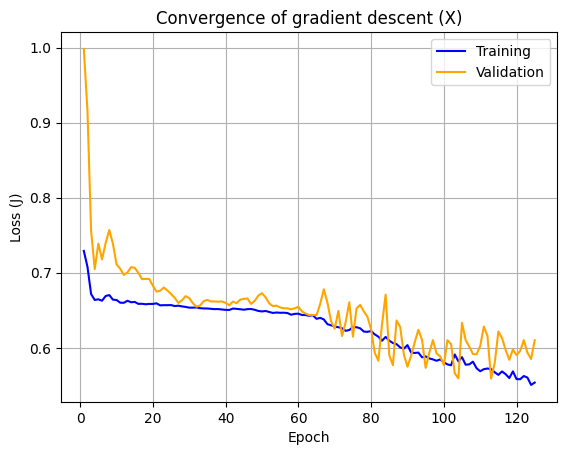

In [19]:
plot_convergence(loss_train, loss_val)

### Total arrival delay regression

#### Gradient descent regression

2025-12-07 16:19:42.774256 Epoch 1: training loss 4326.7520, validation loss 4616.0537
2025-12-07 16:19:42.782943 Epoch 2: training loss 4277.1543, validation loss 4566.6304
2025-12-07 16:19:42.791391 Epoch 3: training loss 4247.1387, validation loss 4536.7681
2025-12-07 16:19:42.798580 Epoch 4: training loss 4228.6416, validation loss 4518.3848
2025-12-07 16:19:42.805943 Epoch 5: training loss 4217.0889, validation loss 4506.9058
2025-12-07 16:19:42.813039 Epoch 6: training loss 4209.8037, validation loss 4499.6626
2025-12-07 16:19:42.820470 Epoch 7: training loss 4205.1753, validation loss 4495.0552
2025-12-07 16:19:42.827885 Epoch 8: training loss 4202.2202, validation loss 4492.1055
2025-12-07 16:19:42.835362 Epoch 9: training loss 4200.3262, validation loss 4490.2070
2025-12-07 16:19:42.842620 Epoch 10: training loss 4199.1089, validation loss 4488.9790
2025-12-07 16:19:42.849961 Epoch 11: training loss 4198.3237, validation loss 4488.1812
2025-12-07 16:19:42.857449 Epoch 12: trai

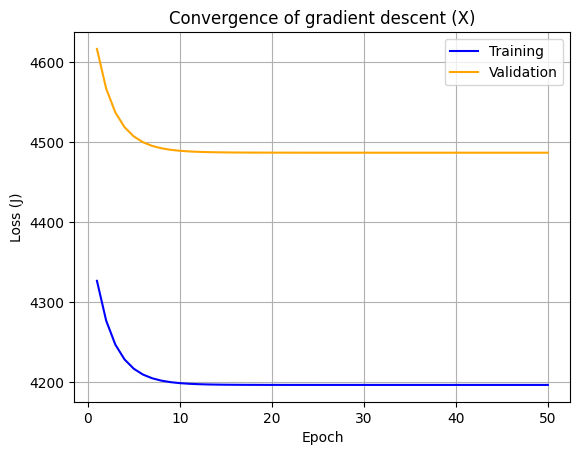

In [ ]:
# train model with vanilla GD
params = torch.tensor([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], requires_grad=True)
loss_train, loss_val = model_train_vanilla(
  n_epochs=50,
  learning_rate=1e-1,
  params=params,
  X_train=torch.tensor(np.hstack((np.ones((len(X_train),1)),
                                  X_train.numpy())), dtype=torch.float32),
  X_val=torch.tensor(np.hstack((np.ones((len(X_val),1)),
                                X_val.numpy())), dtype=torch.float32),
  y_train=arr_delay_train,
  y_val=arr_delay_val
)
plot_convergence(loss_train, loss_val)

#### Support vector regression

In [ ]:
model = SVR(kernel='rbf', C=1)
model.fit(X_train_svm.numpy(), arr_delay_train_svm.numpy())

SVR(C=1)

In [ ]:
# support vector regression measures fit quality with R^2 score
y_train_pred = model.predict(X_train_svm)
y_val_pred = model.predict(X_val)

TypeError: subtract() received an invalid combination of arguments - got (numpy.ndarray, Tensor), but expected one of:
 * (Tensor input, Tensor other, *, Number alpha = 1, Tensor out = None)
 * (Tensor input, Number other, Number alpha = 1)


In [ ]:
sq_err = np.square(np.subtract(y_train_pred, arr_delay_train_svm))
J_train = (1 / (2 * len(X_train_svm))) * torch.sum(sq_err)
sq_err = np.square(np.subtract(y_val_pred, arr_delay_val))
J_val = (1 / (2 * len(X_val))) * torch.sum(sq_err)

training_metrics = {'Training R^2': model.score(X_train_svm, arr_delay_train_svm),
                    'Validation R^2': model.score(X_val, arr_delay_val),
                    'Training Loss': J_train,
                    'Validation Loss': J_val}

if model.kernel == 'linear':
  print('MODEL: {:.3f}'.format(model.intercept_[0]), end='')
  coefficients = model.coef_[0]
  for i in range(len(coefficients)):
    if coefficients[i] > 0:
      print(' + {:.3f} * x_{}'.format(abs(coefficients[i]), i + 1), end='')
    elif coefficients[i] < 0:
      print(' - {:.3f} * x_{}'.format(abs(coefficients[i]), i + 1), end='')
  print()

for i in training_metrics:
  print("{}: {}".format(i, training_metrics[i]))
print()

/tmp/ipython-input-1934752322.py:1: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  sq_err = np.square(np.subtract(y_train_pred, arr_delay_train_svm))
/tmp/ipython-input-1934752322.py:3: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  sq_err = np.square(np.subtract(y_val_pred, arr_delay_val))


Training R^2: -0.023845872079659713
Validation R^2: -0.023961783061923203
Training Loss: 2009.2472475966522
Validation Loss: 2312.0349430585925



#### FCNN regression

In [77]:
import gc
torch.cuda.empty_cache()
seq_model = nn.Sequential().to(device)
gc.collect()

29

In [14]:
seq_model = nn.Sequential(nn.Linear(8,4096), nn.Tanh(),
                          nn.Linear(4096,2048), nn.Tanh(),
                          nn.Linear(2048,2048), nn.Tanh(),
                          nn.Linear(2048,1024), nn.Tanh(),
                          nn.Linear(1024,512), nn.Tanh(),
                          nn.Linear(512,512), nn.Tanh(),
                          nn.Linear(512,256), nn.Tanh(),
                          nn.Linear(256,64), nn.Tanh(),
                          nn.Linear(64,32), nn.Tanh(),
                          nn.Linear(32,4), nn.Tanh(),
                          nn.Linear(4,1)).to(device)

optimizer = optim.Adam(seq_model.parameters(), lr=1e-4)

loss_train, loss_val = model_train_regression(
    n_epochs=100,
    optimizer=optimizer,
    model=seq_model,
    loss_fn=nn.MSELoss(),
    X_train=X_train.to(device),
    X_val=X_val.to(device),
    y_train=arr_delay_train.to(device),
    y_val=arr_delay_val.to(device)
)

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/loss.py:634: UserWarning: Using a target size (torch.Size([20000])) that is different to the input size (torch.Size([20000, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/tmp/ipython-input-1149227358.py:15: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:836.)
  loss_train_history[epoch-1] = loss_train


2025-12-07 21:47:07.309780 Epoch 1: training loss 5239.0142, validation loss 3984.1736
2025-12-07 21:47:07.668872 Epoch 2: training loss 4248.6538, validation loss 4061.1128
2025-12-07 21:47:08.320093 Epoch 3: training loss 3969.0547, validation loss 4714.7183
2025-12-07 21:47:08.999279 Epoch 4: training loss 3700.1318, validation loss 4757.1899
2025-12-07 21:47:09.658119 Epoch 5: training loss 4843.2476, validation loss 3819.8220
2025-12-07 21:47:10.314000 Epoch 6: training loss 4144.6821, validation loss 4229.7705
2025-12-07 21:47:10.991372 Epoch 7: training loss 4601.8550, validation loss 4443.4766
2025-12-07 21:47:11.661247 Epoch 8: training loss 4958.1079, validation loss 4339.4922
2025-12-07 21:47:12.318471 Epoch 9: training loss 4158.5107, validation loss 4540.4453
2025-12-07 21:47:12.988247 Epoch 10: training loss 4325.4927, validation loss 4770.8086
2025-12-07 21:47:13.632583 Epoch 11: training loss 4449.4370, validation loss 5287.5537
2025-12-07 21:47:14.302419 Epoch 12: trai

Training loss history: [5239.01416016 4248.65380859 3969.0546875  3700.13183594 4843.24755859
 4144.68212891 4601.85498047 4958.10791016 4158.51074219 4325.49267578
 4449.43701172 4019.85839844 4042.46362305 3767.60766602 4708.76074219
 4437.69238281 3822.55224609 4400.64941406 4012.72143555 5137.58007812
 4811.81005859 4281.98632812 3901.20336914 4317.43652344 3839.66699219
 4189.34570312 3788.20166016 3949.45678711 4664.11474609 4020.39038086
 4907.11425781 4584.57080078 4496.77148438 4552.97998047 4379.56787109
 3909.28955078 3960.32348633 4333.03662109 4075.78149414 4989.92822266
 4359.05810547 4563.125      5210.19921875 4361.43896484 4436.55566406
 5023.0625     4292.13671875 4235.71826172 4211.72070312 4646.02734375
 4430.9609375  4004.78881836 3987.38330078 3774.52368164 3890.59008789
 3921.45068359 4652.56201172 3748.53735352 4624.83740234 3998.97021484
 4208.71386719 4289.66552734 3875.38623047 4047.16064453 3848.00195312
 5510.22119141 4670.08105469 4395.39941406 4437.387207

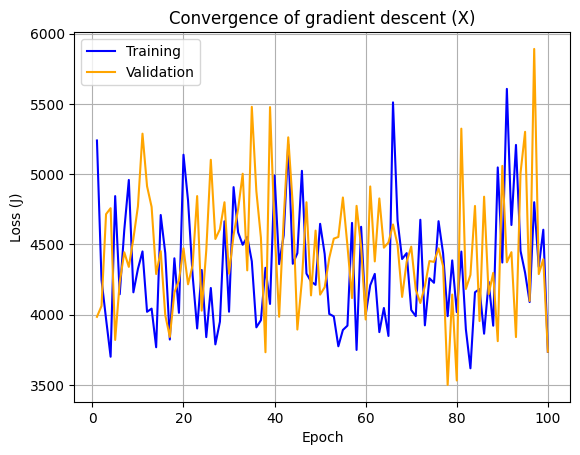

In [15]:
plot_convergence(loss_train, loss_val)

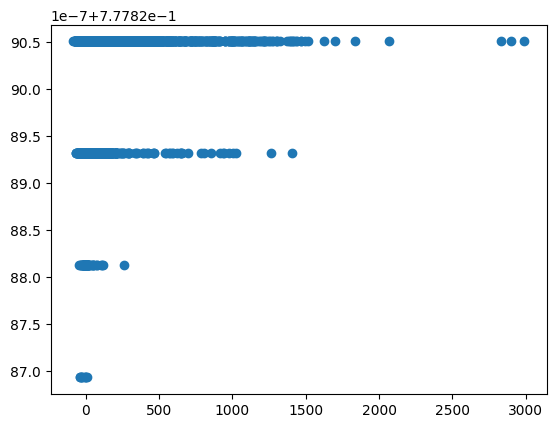

In [16]:
h_val = nn.Sequential().to(device)
h_val = seq_model(X_val.to(device))
plt.scatter(arr_delay_val, h_val.detach().cpu())

### Carrier delay regression

#### Gradient descent regression

2025-12-07 18:17:36.725362 Epoch 1: training loss 1567.4337, validation loss 1770.3442
2025-12-07 18:17:36.735468 Epoch 2: training loss 1555.4615, validation loss 1758.0300
2025-12-07 18:17:36.744244 Epoch 3: training loss 1547.8219, validation loss 1750.1165
2025-12-07 18:17:36.753022 Epoch 4: training loss 1542.9432, validation loss 1745.0171
2025-12-07 18:17:36.761485 Epoch 5: training loss 1539.8256, validation loss 1741.7214
2025-12-07 18:17:36.769514 Epoch 6: training loss 1537.8325, validation loss 1739.5842
2025-12-07 18:17:36.778269 Epoch 7: training loss 1536.5576, validation loss 1738.1925
2025-12-07 18:17:36.788547 Epoch 8: training loss 1535.7422, validation loss 1737.2825
2025-12-07 18:17:36.801387 Epoch 9: training loss 1535.2200, validation loss 1736.6836
2025-12-07 18:17:36.809499 Epoch 10: training loss 1534.8856, validation loss 1736.2871
2025-12-07 18:17:36.818093 Epoch 11: training loss 1534.6713, validation loss 1736.0225
2025-12-07 18:17:36.826898 Epoch 12: trai

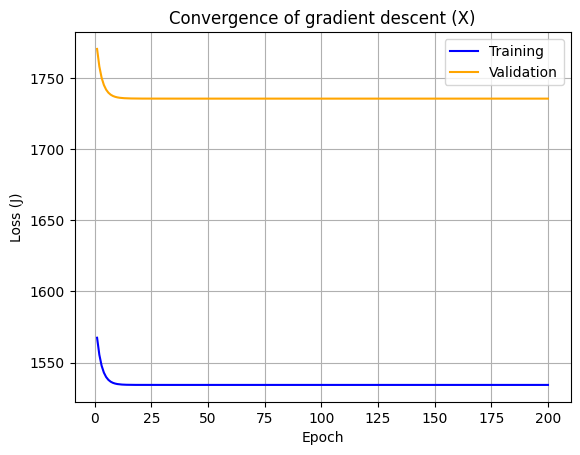

In [ ]:
# train model with vanilla GD
params = torch.tensor([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], requires_grad=True)
loss_train, loss_val = model_train_vanilla(
  n_epochs=200,
  learning_rate=1e-1,
  params=params,
  X_train=torch.tensor(np.hstack((np.ones((len(X_train),1)),
                                  X_train.numpy())), dtype=torch.float32),
  X_val=torch.tensor(np.hstack((np.ones((len(X_val),1)),
                                X_val.numpy())), dtype=torch.float32),
  y_train=carrier_delay_train,
  y_val=carrier_delay_val
)
plot_convergence(loss_train, loss_val)

#### Support vector regression

In [ ]:
model = SVR(kernel='rbf', C=1)
model.fit(X_train_svm.numpy(), carrier_delay_train_svm.numpy())

SVR(C=1)

In [40]:
# support vector regression measures fit quality with R^2 score
y_train_pred = model.predict(X_train_svm)
y_val_pred = model.predict(X_val)

sq_err = np.square(np.subtract(y_train_pred, carrier_delay_train_svm))
J_train = (1 / (2 * len(X_train_svm))) * torch.sum(sq_err)
sq_err = np.square(np.subtract(y_val_pred, carrier_delay_val))
J_val = (1 / (2 * len(X_val))) * torch.sum(sq_err)

training_metrics = {'Training R^2': model.score(X_train_svm, carrier_delay_train_svm),
                    'Validation R^2': model.score(X_val, carrier_delay_val),
                    'Training Loss': J_train,
                    'Validation Loss': J_val}
if model.kernel == 'linear':
  print('MODEL: {:.3f}'.format(model.intercept_[0]), end='')
  coefficients = model.coef_[0]
  for i in range(len(coefficients)):
    if coefficients[i] > 0:
      print(' + {:.3f} * x_{}'.format(abs(coefficients[i]), i + 1), end='')
    elif coefficients[i] < 0:
      print(' - {:.3f} * x_{}'.format(abs(coefficients[i]), i + 1), end='')
  print()

for i in training_metrics:
  print("{}: {}".format(i, training_metrics[i]))
print()

/tmp/ipython-input-3896138404.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  sq_err = np.square(np.subtract(y_train_pred, carrier_delay_train_svm))
/tmp/ipython-input-3896138404.py:7: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  sq_err = np.square(np.subtract(y_val_pred, carrier_delay_val))


Training R^2: -0.02151617128264882
Validation R^2: -0.018828504603051188
Training Loss: 688.7011101096535
Validation Loss: 884.595866613793



#### FCNN regression

In [71]:
seq_model = nn.Sequential(nn.Linear(8,1), nn.Tanh(),
                          nn.Linear(1,4), nn.Tanh(),
                          nn.Linear(4,1)).to(device)

optimizer = optim.SGD(seq_model.parameters(), lr=1e-3)

loss_train, loss_val = model_train_regression(
    n_epochs=200,
    optimizer=optimizer,
    model=seq_model,
    loss_fn=nn.MSELoss(),
    X_train=X_train.to(device),
    X_val=X_val.to(device),
    y_train=carrier_delay_train.to(device),
    y_val=carrier_delay_val.to(device)
)

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/loss.py:634: UserWarning: Using a target size (torch.Size([20000])) that is different to the input size (torch.Size([20000, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


2025-12-07 21:40:57.569985 Epoch 1: training loss 1439.4871, validation loss 1643.3840
2025-12-07 21:40:57.645953 Epoch 2: training loss 1561.5023, validation loss 1377.6267
2025-12-07 21:40:57.723434 Epoch 3: training loss 1424.3918, validation loss 1419.2947
2025-12-07 21:40:57.823131 Epoch 4: training loss 1648.9863, validation loss 1202.7139
2025-12-07 21:40:57.909189 Epoch 5: training loss 1812.4407, validation loss 1680.1506
2025-12-07 21:40:58.005107 Epoch 6: training loss 1960.8468, validation loss 1581.1656
2025-12-07 21:40:58.111384 Epoch 7: training loss 1531.2968, validation loss 1620.0864
2025-12-07 21:40:58.227867 Epoch 8: training loss 1864.1342, validation loss 1086.5291
2025-12-07 21:40:58.295000 Epoch 9: training loss 1524.5002, validation loss 1321.4000
2025-12-07 21:40:58.363043 Epoch 10: training loss 1910.3197, validation loss 1480.7931
2025-12-07 21:40:58.425906 Epoch 11: training loss 1673.4745, validation loss 1948.6385
2025-12-07 21:40:58.521408 Epoch 12: trai

Training loss history: [1439.48706055 1561.50231934 1424.3918457  1648.98632812 1812.44067383
 1960.84680176 1531.29675293 1864.13415527 1524.50024414 1910.31970215
 1673.4744873  1367.54187012 1226.28967285 1552.15197754 1566.13635254
 1652.17932129 1706.41394043 1432.4732666  1291.46826172 1531.64746094
 2060.22509766 1362.42236328 1566.99487305 1807.30883789 1595.19799805
 1232.90722656 1503.93737793 1248.40161133 1266.55615234 1378.55554199
 1877.31323242 1812.21069336 1450.33361816 1626.99243164 1764.58203125
 1292.7454834  1272.09387207 1997.890625   1739.84216309 1465.90039062
 1203.5814209  1612.47888184 1431.37072754 1668.34094238 1137.98400879
 1568.2980957  1475.21081543 1442.73510742 2323.26342773 1274.44470215
 1632.12390137 1153.1439209  1927.06689453 2200.32324219 2095.66430664
 1698.44421387 2226.28662109 1630.2644043  1375.1340332  1690.70788574
 1504.62219238 1991.37658691 1515.47546387 1471.98999023 1503.62426758
 1249.24584961 1103.51831055 1541.68786621 1951.541992

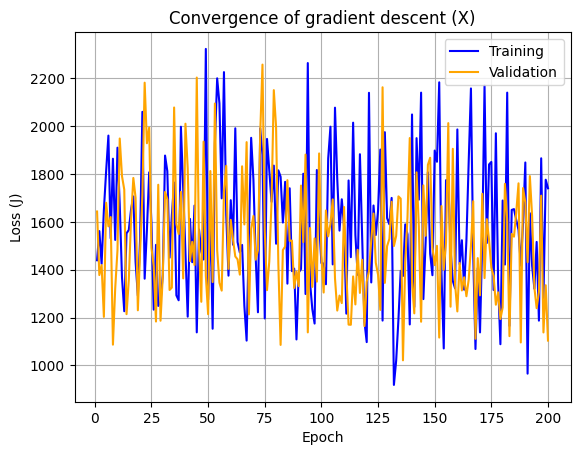

In [72]:
plot_convergence(loss_train, loss_val)

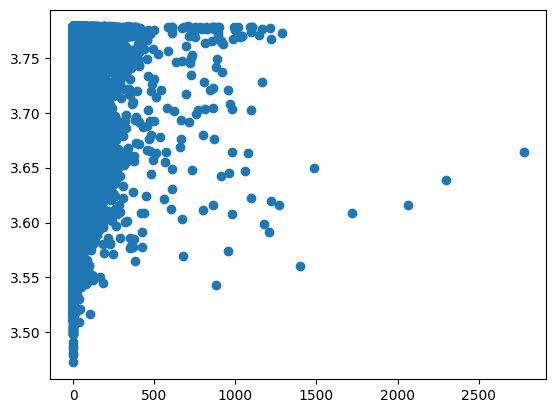

In [73]:
h_val = nn.Sequential().to(device)
h_val = seq_model(X_val.to(device))
plt.scatter(carrier_delay_val, h_val.detach().cpu())

### Late aircraft delay regression

#### Gradient descent regression

2025-12-07 21:14:32.560674 Epoch 1: training loss 1136.6112, validation loss 1257.4320
2025-12-07 21:14:32.568194 Epoch 2: training loss 1134.1841, validation loss 1254.9685
2025-12-07 21:14:32.574595 Epoch 3: training loss 1131.8672, validation loss 1252.6161
2025-12-07 21:14:32.581134 Epoch 4: training loss 1129.6556, validation loss 1250.3698
2025-12-07 21:14:32.587356 Epoch 5: training loss 1127.5443, validation loss 1248.2240
2025-12-07 21:14:32.593555 Epoch 6: training loss 1125.5281, validation loss 1246.1743
2025-12-07 21:14:32.599734 Epoch 7: training loss 1123.6027, validation loss 1244.2163
2025-12-07 21:14:32.605988 Epoch 8: training loss 1121.7632, validation loss 1242.3450
2025-12-07 21:14:32.611910 Epoch 9: training loss 1120.0062, validation loss 1240.5570
2025-12-07 21:14:32.617949 Epoch 10: training loss 1118.3275, validation loss 1238.8475
2025-12-07 21:14:32.624135 Epoch 11: training loss 1116.7234, validation loss 1237.2135
2025-12-07 21:14:32.630142 Epoch 12: trai

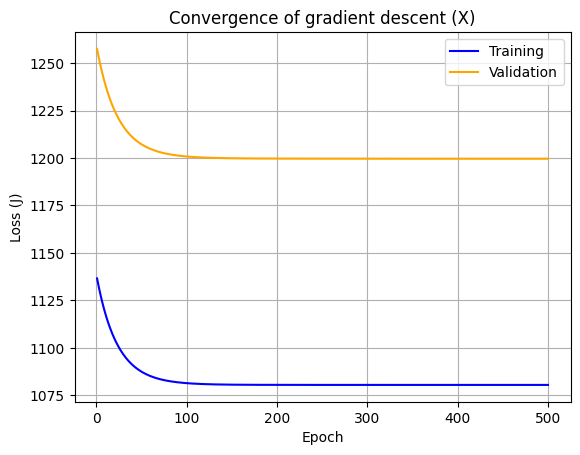

In [17]:
# train model with vanilla GD
params = torch.tensor([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], requires_grad=True)
loss_train, loss_val = model_train_vanilla(
  n_epochs=500,
  learning_rate=1e-2,
  params=params,
  X_train=torch.tensor(np.hstack((np.ones((len(X_train),1)),
                                  X_train.numpy())), dtype=torch.float32),
  X_val=torch.tensor(np.hstack((np.ones((len(X_val),1)),
                                X_val.numpy())), dtype=torch.float32),
  y_train=late_aircraft_delay_train,
  y_val=late_aircraft_delay_val
)
plot_convergence(loss_train, loss_val)

#### Support vector regression

In [15]:
model = SVR(kernel='rbf', C=1)
model.fit(X_train_svm.numpy(), late_aircraft_delay_train_svm.numpy())

SVR(C=1)

In [16]:
# support vector regression measures fit quality with R^2 score
y_train_pred = model.predict(X_train_svm)
y_val_pred = model.predict(X_val)

sq_err = np.square(np.subtract(y_train_pred, late_aircraft_delay_train_svm))
J_train = (1 / (2 * len(X_train_svm))) * torch.sum(sq_err)
sq_err = np.square(np.subtract(y_val_pred, late_aircraft_delay_val))
J_val = (1 / (2 * len(X_val))) * torch.sum(sq_err)

training_metrics = {'Training R^2': model.score(X_train_svm, late_aircraft_delay_train_svm),
                    'Validation R^2': model.score(X_val, arr_delay_val),
                    'Training Loss': J_train,
                    'Validation Loss': J_val}

if model.kernel == 'linear':
  print('MODEL: {:.3f}'.format(model.intercept_[0]), end='')
  coefficients = model.coef_[0]
  for i in range(len(coefficients)):
    if coefficients[i] > 0:
      print(' + {:.3f} * x_{}'.format(abs(coefficients[i]), i + 1), end='')
    elif coefficients[i] < 0:
      print(' - {:.3f} * x_{}'.format(abs(coefficients[i]), i + 1), end='')
  print()

for i in training_metrics:
  print("{}: {}".format(i, training_metrics[i]))
print()

/tmp/ipython-input-3874236885.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  sq_err = np.square(np.subtract(y_train_pred, late_aircraft_delay_train_svm))
/tmp/ipython-input-3874236885.py:7: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  sq_err = np.square(np.subtract(y_val_pred, late_aircraft_delay_val))


Training R^2: -0.038117235227000945
Validation R^2: -0.02329043763812888
Training Loss: 668.1422766478329
Validation Loss: 568.4952963778065



#### FCNN regression

In [76]:
seq_model = nn.Sequential().to(device)

In [75]:
seq_model = nn.Sequential(nn.Linear(8,4096), nn.Tanh(),
                          nn.Linear(4096,2048), nn.Tanh(),
                          nn.Linear(2048,1024), nn.Tanh(),
                          # nn.Linear(1024,1024), nn.Tanh(),
                          # nn.Linear(1024,1024), nn.Tanh(),
                          # nn.Linear(1024,1024), nn.Tanh(),
                          # nn.Linear(1024,1024), nn.Tanh(),
                          # nn.Linear(1024,1024), nn.Tanh(),
                          # nn.Linear(1024,1024), nn.Tanh(),
                          # nn.Linear(1024,1024), nn.Tanh(),
                          # nn.Linear(1024,1024), nn.Tanh(),
                          # nn.Linear(1024,1024), nn.Tanh(),
                          # nn.Linear(1024,1024), nn.Tanh(),
                          # nn.Linear(1024,1024), nn.Tanh(),
                          # nn.Linear(1024,1024), nn.Tanh(),
                          # nn.Linear(1024,1024), nn.Tanh(),
                          # nn.Linear(1024,1024), nn.Tanh(),
                          # nn.Linear(1024,1024), nn.Tanh(),
                          # nn.Linear(1024,1024), nn.Tanh(),
                          # nn.Linear(1024,1024), nn.Tanh(),
                          # nn.Linear(1024,1024), nn.Tanh(),
                          # nn.Linear(1024,1024), nn.Tanh(),
                          # nn.Linear(1024,1024), nn.Tanh(),
                          # nn.Linear(1024,1024), nn.Tanh(),
                          # nn.Linear(1024,1024), nn.Tanh(),
                          # nn.Linear(1024,1024), nn.Tanh(),
                          # nn.Linear(1024,1024), nn.Tanh(),
                          # nn.Linear(1024,1024), nn.Tanh(),
                          # nn.Linear(1024,1024), nn.Tanh(),
                          # nn.Linear(1024,1024), nn.Tanh(),
                          # nn.Linear(1024,1024), nn.Tanh(),
                          # nn.Linear(1024,1024), nn.Tanh(),
                          # nn.Linear(1024,1024), nn.Tanh(),
                          # nn.Linear(1024,1024), nn.Tanh(),
                          # nn.Linear(1024,1024), nn.Tanh(),
                          # nn.Linear(1024,1024), nn.Tanh(),
                          # nn.Linear(1024,1024), nn.Tanh(),
                          # nn.Linear(1024,1024), nn.Tanh(),
                          # nn.Linear(1024,1024), nn.Tanh(),
                          # nn.Linear(1024,1024), nn.Tanh(),
                          # nn.Linear(1024,1024), nn.Tanh(),
                          # nn.Linear(1024,1024), nn.Tanh(),
                          # nn.Linear(1024,1024), nn.Tanh(),
                          # nn.Linear(1024,1024), nn.Tanh(),
                          # nn.Linear(1024,1024), nn.Tanh(),
                          # nn.Linear(1024,1024), nn.Tanh(),
                          # nn.Linear(1024,1024), nn.Tanh(),
                          # nn.Linear(1024,1024), nn.Tanh(),
                          nn.Linear(1024,1024), nn.Tanh(),
                          nn.Linear(1024,512), nn.Tanh(),
                          nn.Linear(512,512), nn.Tanh(),
                          nn.Linear(512,256), nn.Tanh(),
                          nn.Linear(256,32), nn.Tanh(),
                          nn.Linear(32,4), nn.Tanh(),
                          nn.Linear(4,1)).to(device)

optimizer = optim.AdamW(seq_model.parameters(), lr=1e-2)

loss_train, loss_val = model_train_regression_lambda(
    n_epochs=100,
    optimizer=optimizer,
    model=seq_model,
    loss_fn=nn.MSELoss(),
    X_train=X_train.to(device),
    X_val=X_val.to(device),
    y_train=late_aircraft_delay_train.to(device),
    y_val=late_aircraft_delay_val.to(device),
    l2_lambda=0.05
)

OutOfMemoryError: CUDA out of memory. Tried to allocate 1.49 GiB. GPU 0 has a total capacity of 14.74 GiB of which 804.12 MiB is free. Process 2514 has 13.95 GiB memory in use. Of the allocated memory 13.01 GiB is allocated by PyTorch, and 836.40 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

Training loss history: [1292.4296875  1190.64038086 1364.40771484 1069.25231934  979.15222168
 1154.35693359  992.99212646 1170.78015137 1031.98486328  980.15081787
  836.68829346 1113.37072754 1052.32336426  974.18811035  906.93786621
  996.08410645 1014.53973389 1018.43139648  863.61212158 1036.45251465
 1082.29309082 1139.03710938 1205.67443848 1253.51208496 1210.81152344
 1303.21850586 1234.54736328  930.19274902 1069.33044434 1211.21594238
  881.42462158 1197.8458252   938.36328125 1063.94763184 1234.63513184
  995.90075684  901.97113037 1321.71264648 1153.95471191 1064.08203125
 1093.98950195 1106.11791992 1376.65283203 1439.48742676 1005.1663208
 1035.51159668 1264.50256348 1356.42919922  912.22662354 1263.82446289
  980.60595703 1104.86901855  978.78015137 1178.71472168 1199.78479004
 1385.16772461  929.61907959  954.85687256 1212.50854492 1050.26208496
 1073.32226562  921.65112305 1033.59228516 1046.03820801 1095.34399414
 1143.08117676 1030.67150879 1223.63378906 1143.1906738

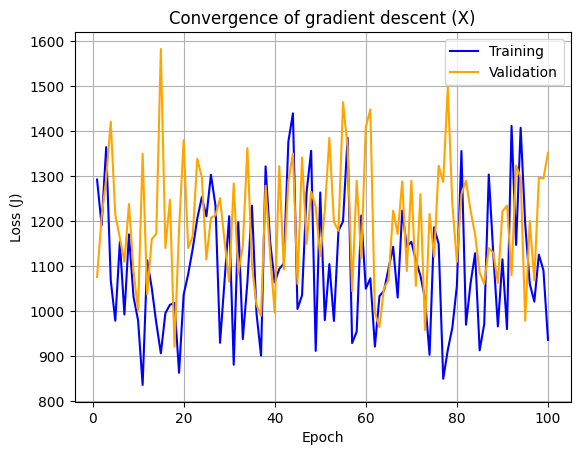

In [19]:
plot_convergence(loss_train, loss_val)

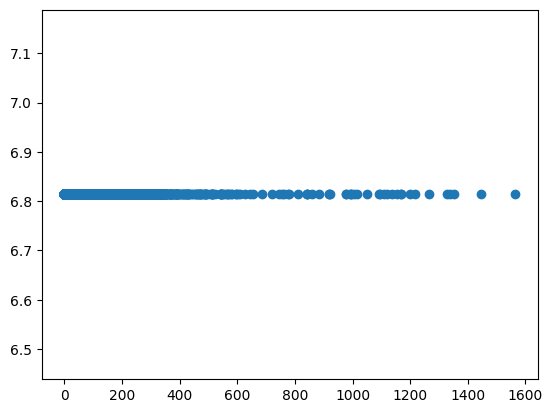

In [20]:
h_val = nn.Sequential().to(device)
h_val = seq_model(X_val.to(device))
plt.scatter(late_aircraft_delay_val, h_val.detach().cpu())